## Custom Modelling

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Read data from stored csv files
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')
Final_Dataset_Provider_Test = Final_Dataset_Provider_Test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

1) Split your whole data into train and test(80-20)



2) Now, in the 80% train set, split the train set into D1 and D2.(50-50).



From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).



Now create 'k' models and train each of these models with each of these k samples.



3) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.



4) Now, using these k predictions, create a new dataset, and for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.



5) Now, for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.



I hope you got it. For base models, you can consider any Tree-based model; you can take the Decision Tree itself. And here, you can tune for the number of base models. The procedure mentioned above requires you to do custom coding. There are no library functions available for this as it is a custom model implementation.

In [3]:
Final_Dataset_Provider_Train.head(2)

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Hospitalization_Duration,Claim_Period,ExtraClaimDays,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,...,PerProviderClmDiagnosisCode_4_count_ClaimID,PerProviderClmDiagnosisCode_5_count_ClaimID,PerProviderClmDiagnosisCode_6_count_ClaimID,PerProviderDiagnosisGroupCode_count_ClaimID,Gender_0,Gender_1,Race_1,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,30.0,61,0.0,5,8,300,...,297,297,297,405,16.0,9.0,21.0,4.0,0.0,0.0
1,PRV51003,1,605670,66286.0,382.0,617,0.0,62,29,1560,...,3046,4452,5556,4972,78.0,54.0,107.0,24.0,0.0,1.0


In [4]:
Final_Dataset_Provider_Train.shape, Final_Dataset_Provider_Test.shape

((5410, 247), (1353, 246))

#### Split your whole data into train and test(80-20)

In [4]:
# Split your whole data into train and test(80-20)
from sklearn.model_selection import train_test_split
Final_Dataset_Provider_Tr, Final_Dataset_Provider_val = train_test_split(Final_Dataset_Provider_Train, test_size=0.2,
                               random_state=42,stratify=Final_Dataset_Provider_Train['PotentialFraud'])
Final_Dataset_Provider_Tr.shape, Final_Dataset_Provider_val.shape

((4328, 247), (1082, 247))

In [5]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Tr.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Tr['PotentialFraud']
x_train.shape, y_train.shape

((4328, 245), (4328,))

In [6]:
# prepare test data
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [7]:
# Seperate dependent and independent variables
x_validation_provider_labels = Final_Dataset_Provider_val[['Provider','PotentialFraud']]
x_validation = Final_Dataset_Provider_val.drop(columns=['Provider','PotentialFraud'],axis=1)
y_validation = Final_Dataset_Provider_val['PotentialFraud']
x_validation.shape, y_validation.shape

((1082, 245), (1082,))

In [8]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_tr = standard_scaler.transform(x_train)
x_val = standard_scaler.transform(x_validation)
x_test_std = standard_scaler.transform(x_test)

# convert pandas.core.series.Series to numpy.ndarray
y_tr = y_train.to_numpy()
y_val = y_validation.to_numpy()

In [9]:
x_val.shape, y_val.shape

((1082, 245), (1082,))

#### Now, in the 80% train set, split the train set into D1 and D2.(50-50)

In [10]:
# Now, in the 80% train set, split the train set into D1 and D2.(50-50)
x_d1, x_d2, y_d1, y_d2 = train_test_split(x_tr, y_tr, test_size=0.5,random_state=42,stratify=y_tr)
x_d1.shape, x_d2.shape, y_d1.shape, y_d2.shape

((2164, 245), (2164, 245), (2164,), (2164,))

In [11]:
from sklearn.metrics import roc_curve, auc , f1_score
import matplotlib.pyplot as plt
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [12]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    # plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [13]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

#### Define a function to randomly sample data from dataset

In [14]:
# define a function to randomly sample data from dataset
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
import numpy as np
def row_col_sampling(x, y):
    total_row_count = x.shape[0]
    total_col_count = x.shape[1]
    # in sampled data i want to keep minimum 40% to maximum 60% number of rows
    sampled_row_count_min = round(total_row_count * 0.4)
    sampled_row_count_max = round(total_row_count * 0.6)
    # in a single dataset the rows should be unique, so setting "replace=False"
    sampled_row_indices = np.random.choice(total_row_count, np.random.randint(sampled_row_count_min,
                                                                              sampled_row_count_max),replace=False)
    sampled_row_indices = np.sort(sampled_row_indices)
    
    sampled_col_count_min = round(total_col_count * 0.4)
    sampled_col_count_max = round(total_col_count * 0.6)
    sampled_col_indices = np.random.choice(total_col_count, np.random.randint(sampled_col_count_min,
                                                                              sampled_col_count_max),replace=False)
    sampled_col_indices = np.sort(sampled_col_indices)
    # now select the sampled rows and columns from the input data
    
    #print(len(sampled_row_indices), len(sampled_col_indices))
    x_sampled = x[sampled_row_indices[:,None], sampled_col_indices]
    y_sampled = y[sampled_row_indices]
    #print(x_sampled.shape)
    
    return x_sampled, y_sampled, sampled_row_indices, sampled_col_indices

#### Function to create k sampled dataset

In [15]:
def create_k_dataset(x_tr, x_te, y_tr, y_te, k):
    x_tr_list = []
    y_tr_list = []
    x_te_list = []
    # y_te_list = []
    sampled_col_indices_list = []
    for i in range(k):
        x_sampled, y_sampled, sampled_row_indices, sampled_col_indices = row_col_sampling(x_tr, y_tr)
        x_tr_list.append(x_sampled)
        y_tr_list.append(y_sampled)
        x_te_list.append(x_te[:,sampled_col_indices])
        # y_te_list.append(y_te)
        sampled_col_indices_list.append(sampled_col_indices)
    return x_tr_list, y_tr_list, x_te_list, y_te, sampled_col_indices_list

#### Function to train k sampled dataset using decision tree, then create data for meta model

## Base Learner - DecisionTreeClassifier

In [17]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50, min_samples_split = 100)
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9343453840796925
Test AUC =  0.9462056297372856


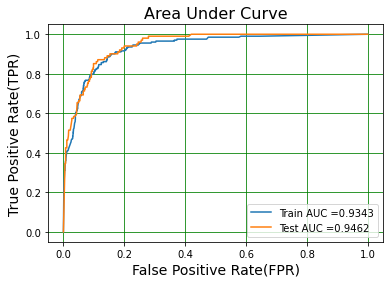

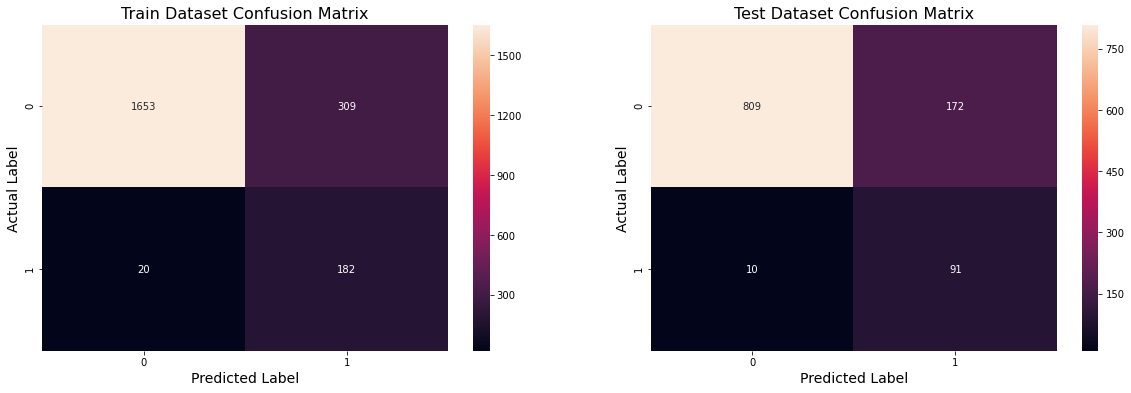

Best Threshold = 0.1019
Model AUC is : 0.9462
Model F1 Score is : 0.5000
						Number of base learners =  20
Train AUC =  0.9381377357919278
Test AUC =  0.9514841392396121


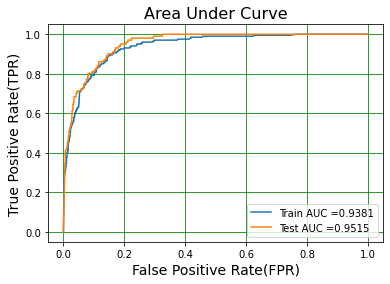

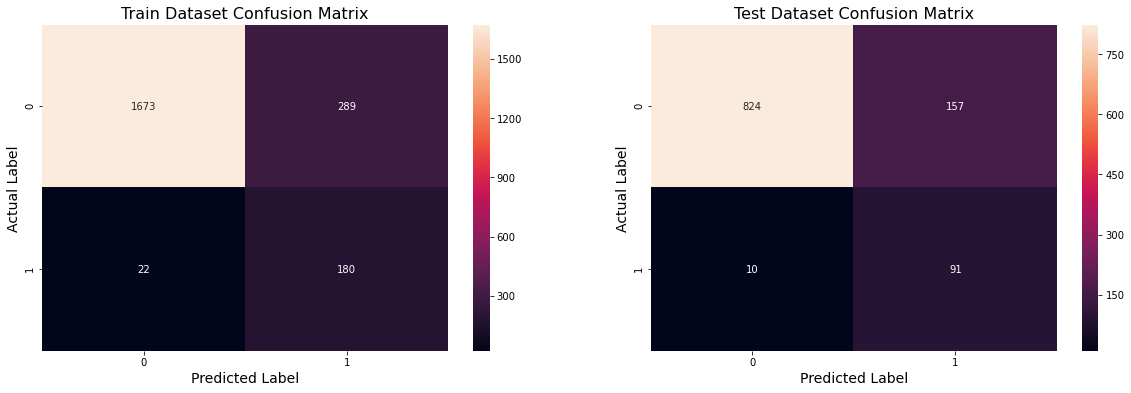

Best Threshold = 0.1095
Model AUC is : 0.9515
Model F1 Score is : 0.5215
						Number of base learners =  50
Train AUC =  0.9399720935396292
Test AUC =  0.9508129712053773


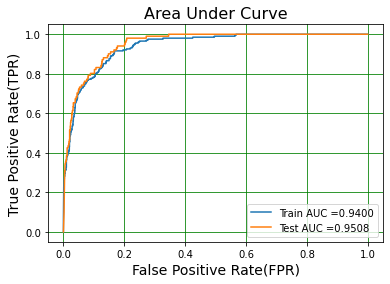

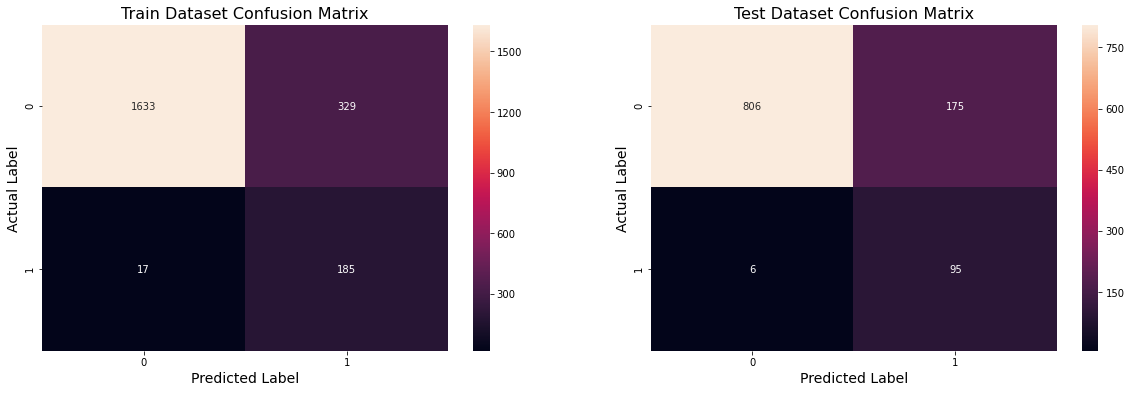

Best Threshold = 0.0995
Model AUC is : 0.9508
Model F1 Score is : 0.5121
						Number of base learners =  80
Train AUC =  0.9406760630191459
Test AUC =  0.9525842492506131


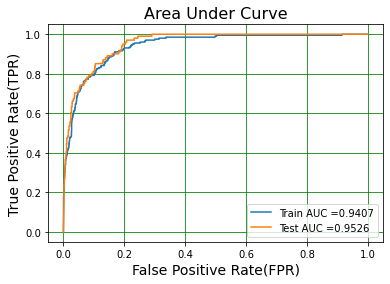

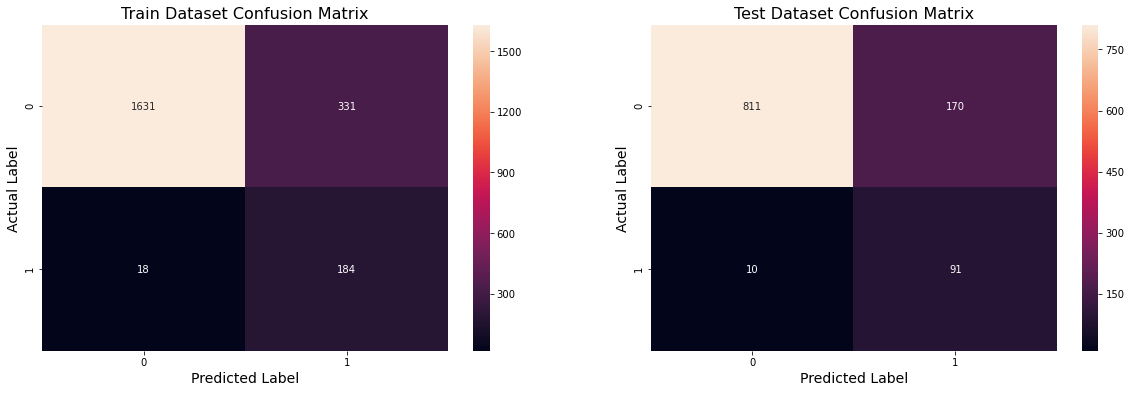

Best Threshold = 0.1028
Model AUC is : 0.9526
Model F1 Score is : 0.5028
						Number of base learners =  100
Train AUC =  0.9413548006176764
Test AUC =  0.9524126724599066


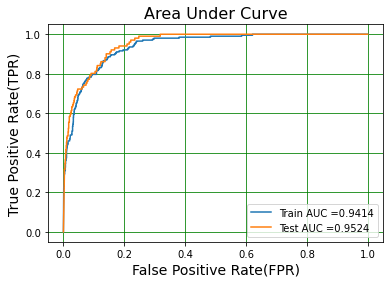

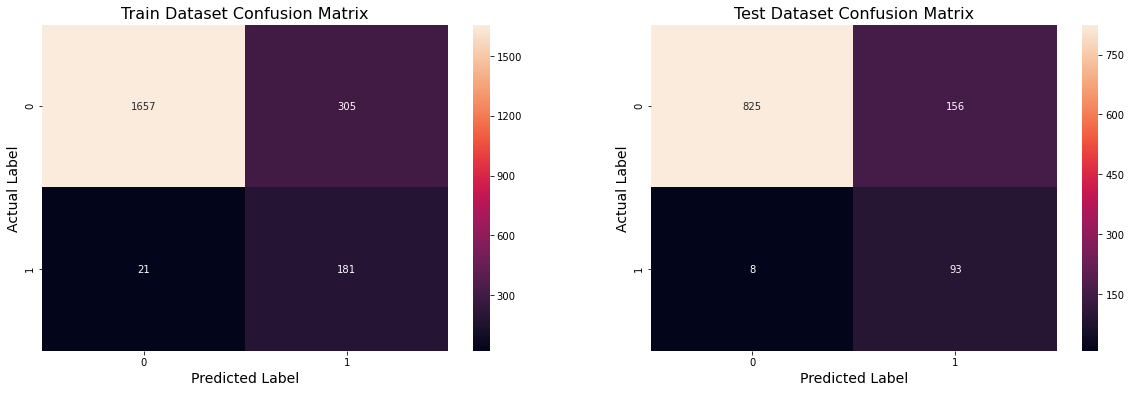

Best Threshold = 0.0958
Model AUC is : 0.9524
Model F1 Score is : 0.5314
						Number of base learners =  150
Train AUC =  0.9417723882479991
Test AUC =  0.9538105186665455


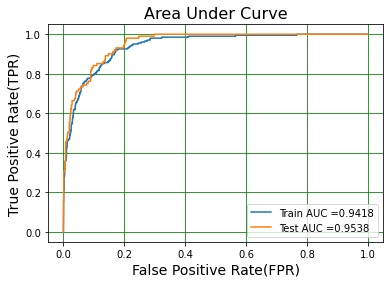

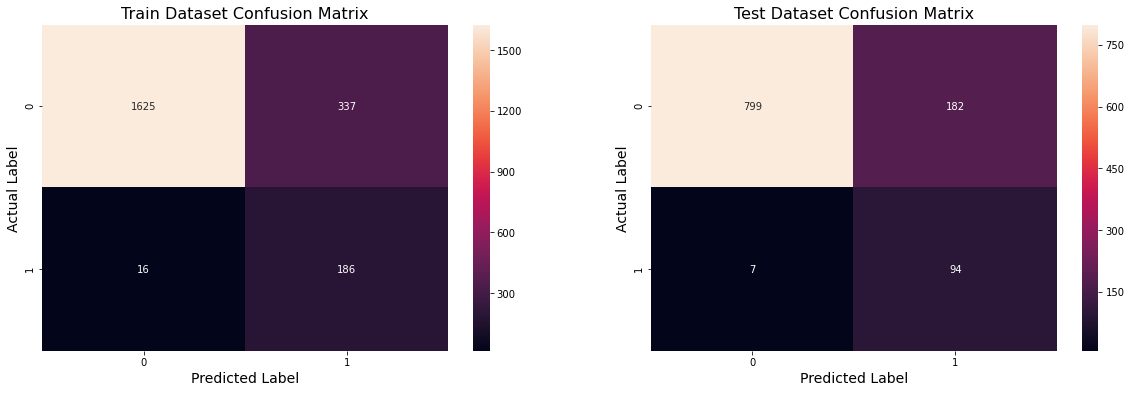

Best Threshold = 0.0802
Model AUC is : 0.9538
Model F1 Score is : 0.4987
						Number of base learners =  175
Train AUC =  0.9419591041672974
Test AUC =  0.952720501407939


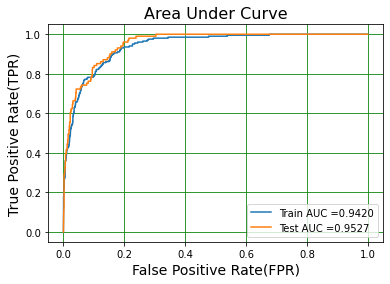

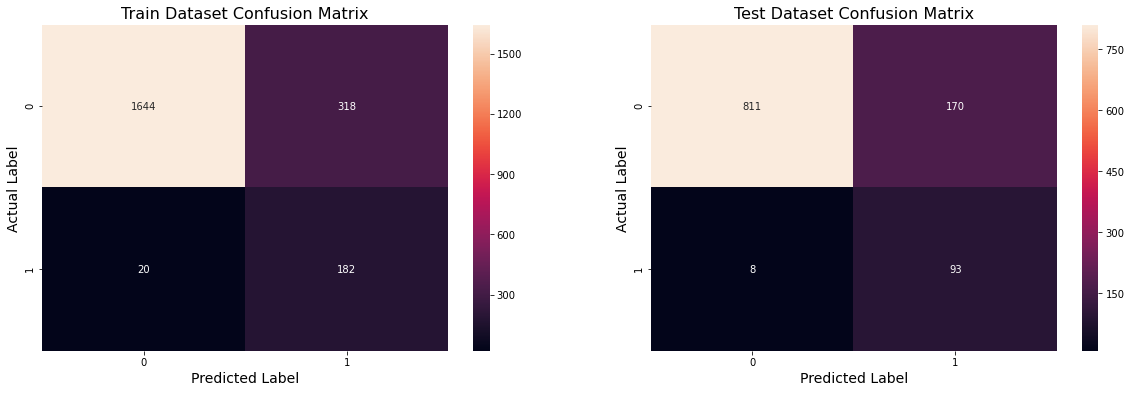

Best Threshold = 0.0886
Model AUC is : 0.9527
Model F1 Score is : 0.5110
						Number of base learners =  200
Train AUC =  0.9422353932640971
Test AUC =  0.9521098898880714


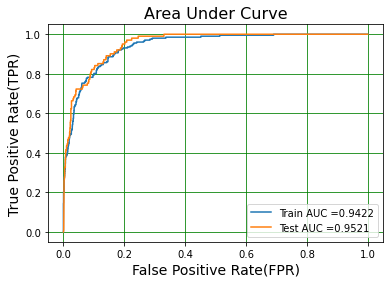

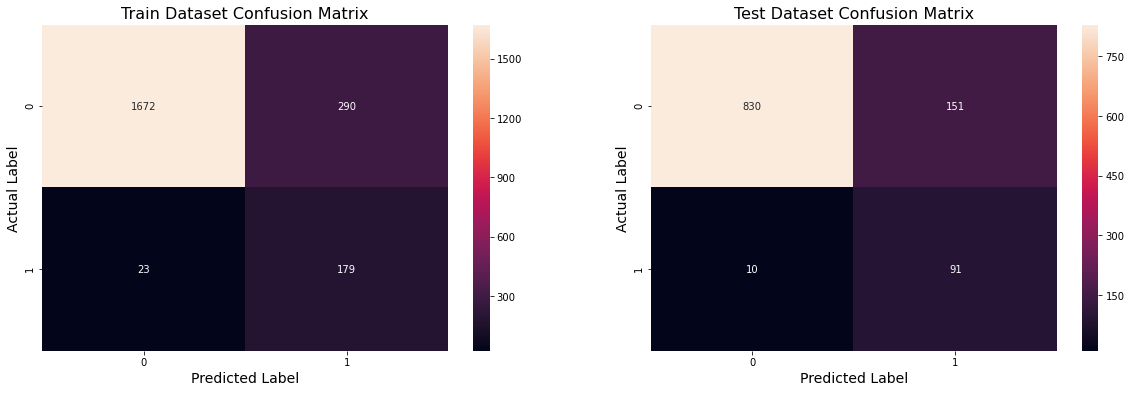

Best Threshold = 0.0951
Model AUC is : 0.9521
Model F1 Score is : 0.5306


In [20]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [23]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.append_row(["10", "Logistic Regression", "0.9462", "0.5000"])
table.append_row(["20", "Logistic Regression", "0.9515", "0.5215"])
table.append_row(["50", "Logistic Regression", "0.9508", "0.5121"])
table.append_row(["80", "Logistic Regression", "0.9526", "0.5028"])
table.append_row(["100", "Logistic Regression", "0.9524", "0.5314"])
table.append_row(["150", "Logistic Regression", "0.9538", "0.4987"])
table.append_row(["175", "Logistic Regression", "0.9527", "0.5110"])
table.append_row(["200", "Logistic Regression", "0.9521", "0.5306"])
print(table)

+----------+---------------------+-------+----------+
| No of DT |     Meta Model      |  AUC  | F1 Score |
+----------+---------------------+-------+----------+
|    10    | Logistic Regression | 0.946 |   0.5    |
+----------+---------------------+-------+----------+
|    20    | Logistic Regression | 0.952 |  0.521   |
+----------+---------------------+-------+----------+
|    50    | Logistic Regression | 0.951 |  0.512   |
+----------+---------------------+-------+----------+
|    80    | Logistic Regression | 0.953 |  0.503   |
+----------+---------------------+-------+----------+
|   100    | Logistic Regression | 0.952 |  0.531   |
+----------+---------------------+-------+----------+
|   150    | Logistic Regression | 0.954 |  0.499   |
+----------+---------------------+-------+----------+
|   175    | Logistic Regression | 0.953 |  0.511   |
+----------+---------------------+-------+----------+
|   200    | Logistic Regression | 0.952 |  0.531   |
+----------+----------------

### Observation:

If we look only at AUC and F1 Score, meta model is working best with 20 base learners. But in our case False Negative(Predicted not Fraud, but actually it is fraud) also a main factor. If we take False negative into consideration, model is working best with 50 base learners. 

In [24]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [25]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

### Now, train different meta model on new created dataset

### Logistic Regression

In [26]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93959096        nan 0.94003109        nan 0.94019896
        nan 0.93374455        nan 0.92702327        nan 0.92564653
        nan 0.92547055]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.94001868        nan 0.94140288        nan 0.94773532
        nan 0.95354991        nan 0.95448144        nan 0.95439578
        nan 0.95439032]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [27]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9401989639180938


Train AUC =  0.9474457766877605
Test AUC =  0.9525287391124433


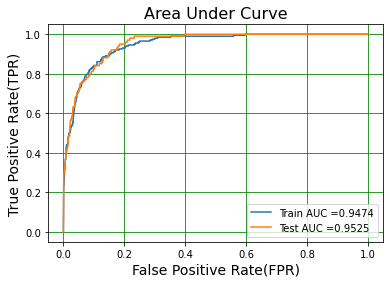

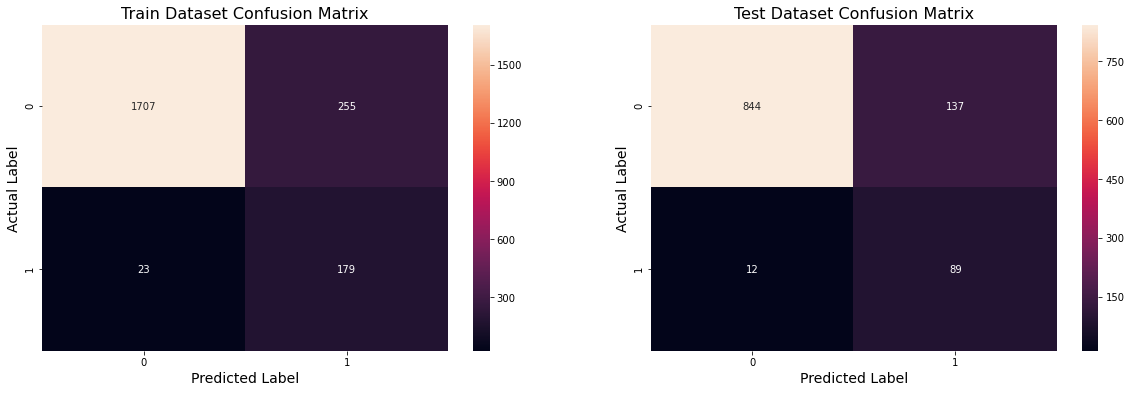

Best Threshold = 0.1009
Model AUC is : 0.9525
Model F1 Score is : 0.5443


In [28]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [112]:
from beautifultable import BeautifulTable
combined_table = BeautifulTable()
combined_table.column_headers= ["Model Combination", "No of base Learners", "AUC", "F1 Score"]
combined_table.append_row(["DT + LR", "50", "0.9525", "0.5443"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+


### Decision Tree

In [29]:
# find best parameters for Decision Tree
decisiontree = DecisionTreeClassifier()

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_meta_model, y_te_d2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [30]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 150}
roc_auc_score : 0.909126536343452


Train AUC =  0.9565948567333797
Test AUC =  0.9140551669845883


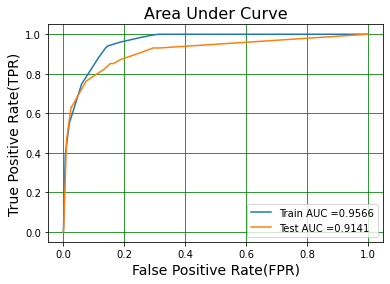

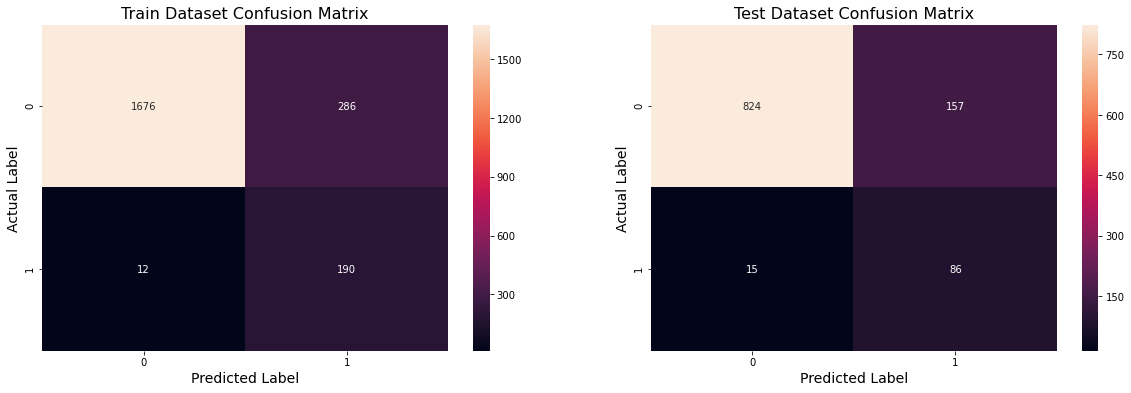

Best Threshold = 0.1250
Model AUC is : 0.9141
Model F1 Score is : 0.5000


In [31]:
decision_tree = DecisionTreeClassifier(criterion = 'entropy' ,max_depth = 5, min_samples_split = 150)
decision_tree.fit(x_tr_meta_model, y_te_d2)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [113]:
combined_table.append_row(["DT + DT", "50", "0.9141", "0.5000"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+


### Support Vector Classifier

In [32]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.91869808        nan 0.91791397]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.95280208        nan 0.9528235 ]
  category=UserWarning


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [33]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.9186980779558145


In [34]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5))

Train AUC =  0.9511472936284455
Test AUC =  0.9424258939655433


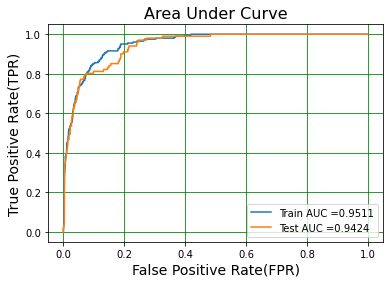

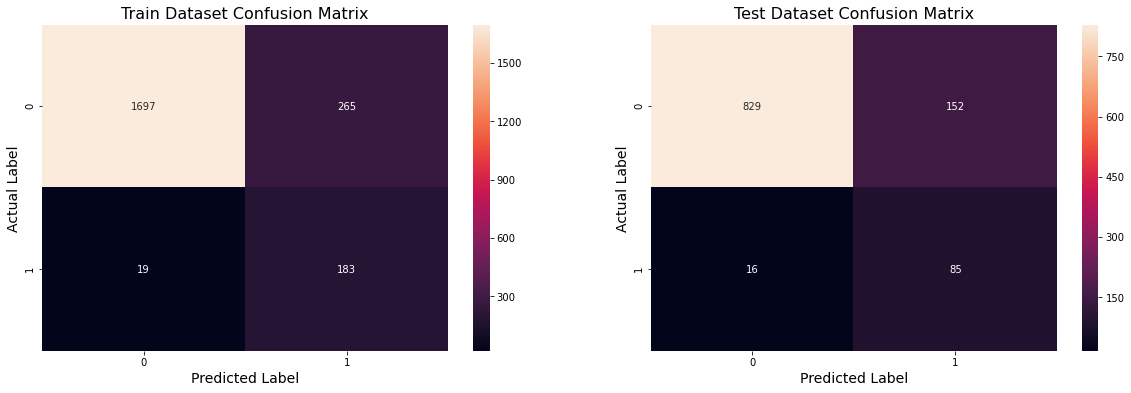

Best Threshold = 0.0881
Model AUC is : 0.9424
Model F1 Score is : 0.5030


In [35]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [114]:
combined_table.append_row(["DT + SVC", "50", "0.9424", "0.5030"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+


### Random Forest

In [36]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [37]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 5}
roc_auc_score : 0.9414046816361996


In [38]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=400,
                       random_state=42)

Train AUC =  0.9668743250471835
Test AUC =  0.9552739677637488


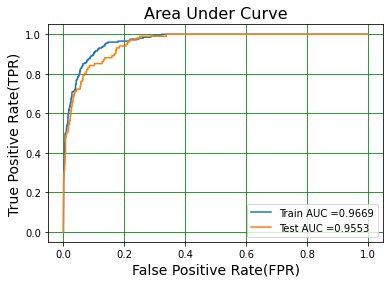

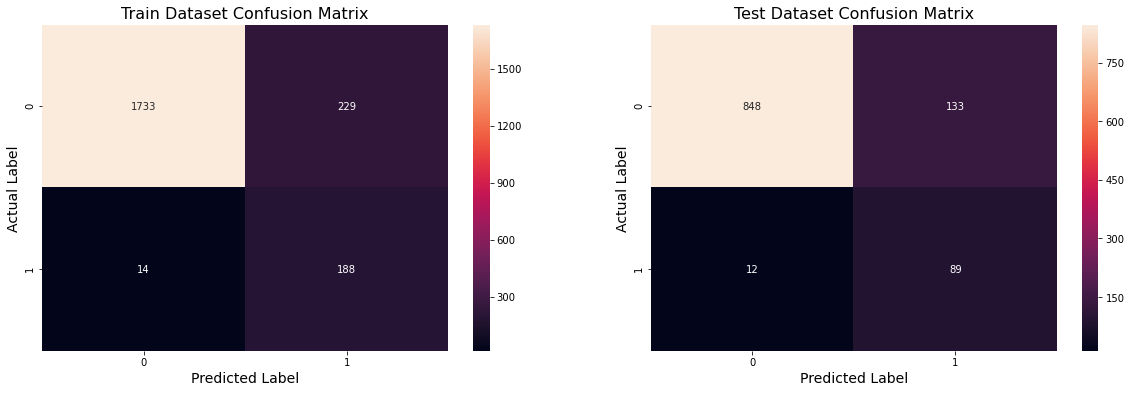

Best Threshold = 0.1135
Model AUC is : 0.9553
Model F1 Score is : 0.5511


In [39]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [115]:
combined_table.append_row(["DT + RF", "50", "0.9553", "0.5511"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+


## BaseLearner - LogisticRegression

In [39]:
# LogisticRegression
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = LogisticRegression(C=0.001,penalty="l2")
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.973135616313925
Test AUC =  0.9468566122667312


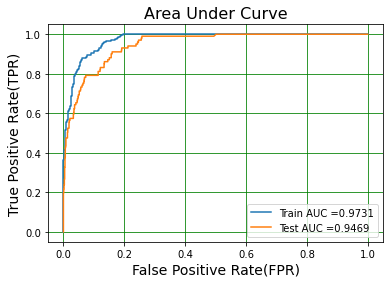

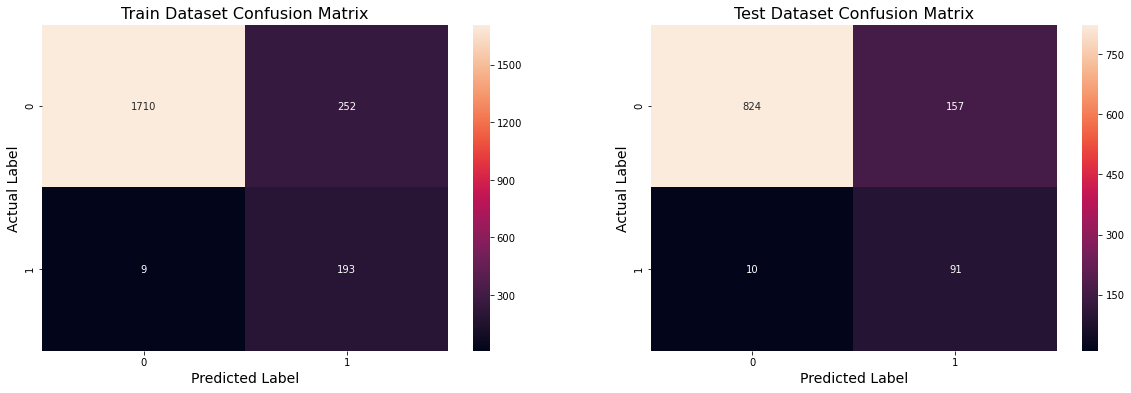

Best Threshold = 0.1097
Model AUC is : 0.9469
Model F1 Score is : 0.5215
						Number of base learners =  20
Train AUC =  0.9738168771005542
Test AUC =  0.9439852242104945


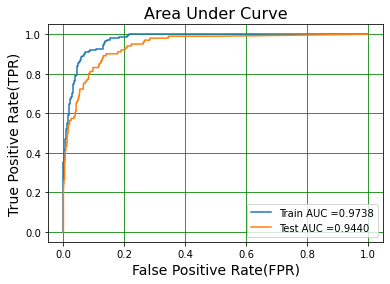

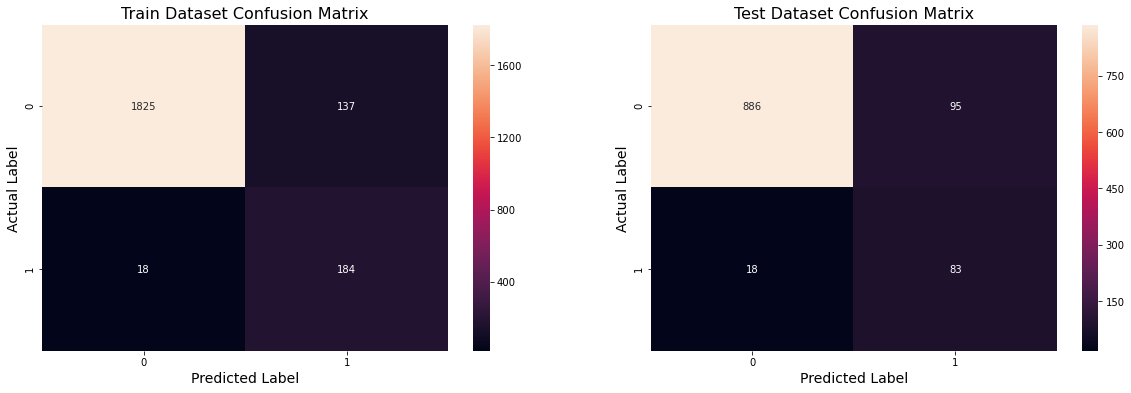

Best Threshold = 0.1874
Model AUC is : 0.9440
Model F1 Score is : 0.5950
						Number of base learners =  50
Train AUC =  0.975371160969308
Test AUC =  0.9440255952200725


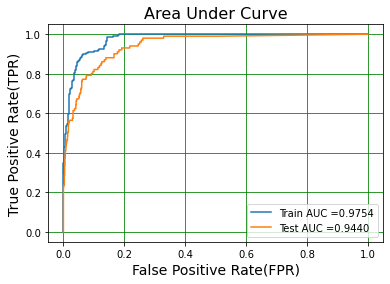

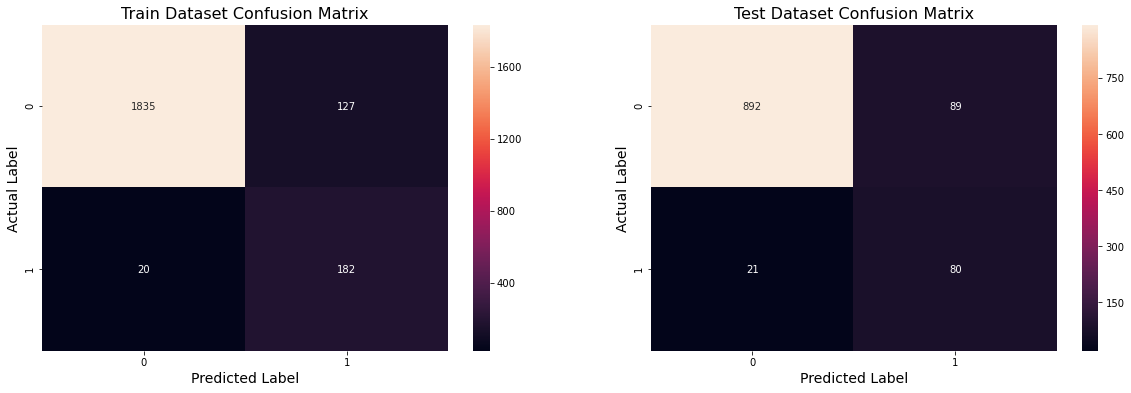

Best Threshold = 0.1927
Model AUC is : 0.9440
Model F1 Score is : 0.5926
						Number of base learners =  80
Train AUC =  0.9764384695350269
Test AUC =  0.9478759802585763


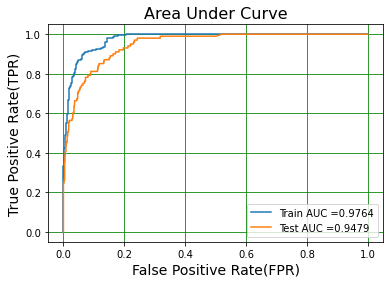

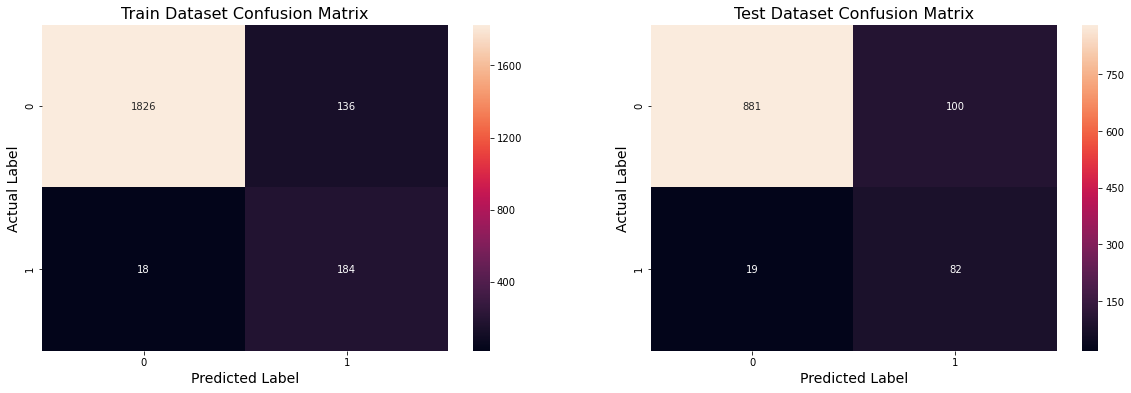

Best Threshold = 0.1860
Model AUC is : 0.9479
Model F1 Score is : 0.5795
						Number of base learners =  100
Train AUC =  0.9770137564215136
Test AUC =  0.9475227339247686


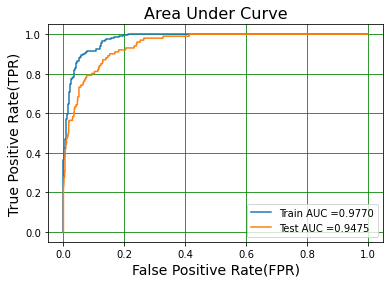

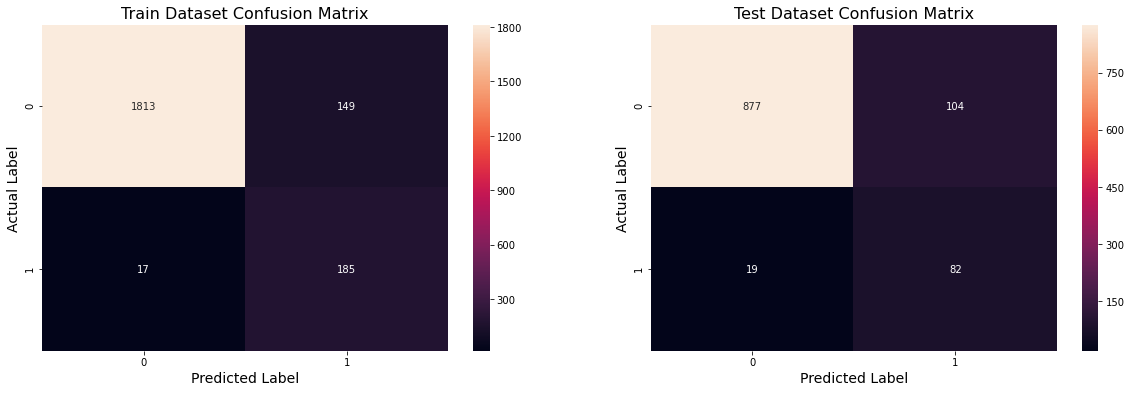

Best Threshold = 0.1729
Model AUC is : 0.9475
Model F1 Score is : 0.5714
						Number of base learners =  150
Train AUC =  0.9780886345515285
Test AUC =  0.9453780240409362


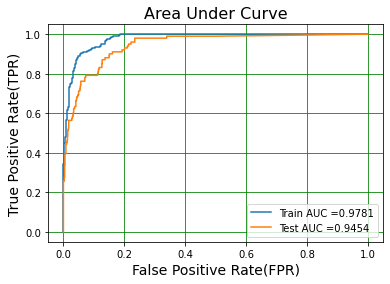

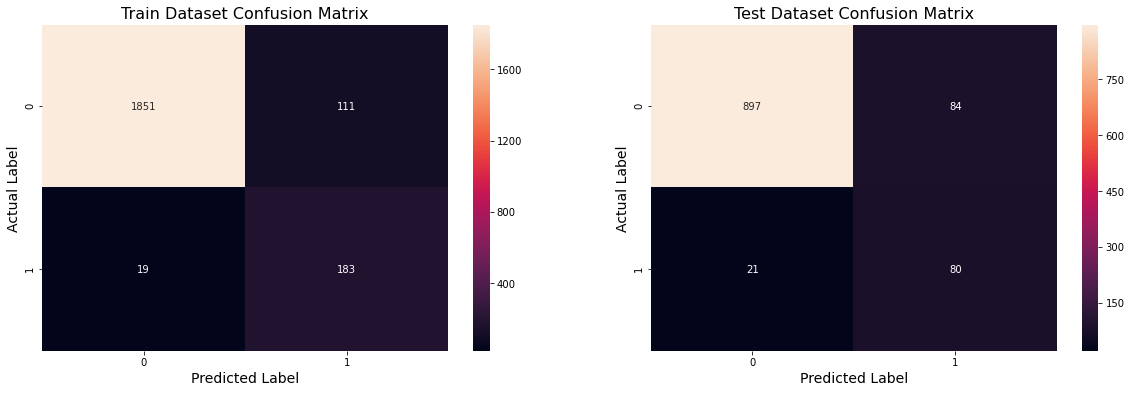

Best Threshold = 0.2009
Model AUC is : 0.9454
Model F1 Score is : 0.6038


In [40]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (RandomForestClassifier regression) using train and validation data from meta model to decide best k
    random_forest = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_features='auto', max_depth=5, random_state=42)
    random_forest.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = random_forest.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Number of base learns, k = 80 working best when base learner is logistic regression. Now tune the meta model.

#### Meta model = Random Forest

In [41]:
# create 80 sampled dataset
k = 80
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [42]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [43]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [44]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 8}
roc_auc_score : 0.9298630332555662


In [47]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=10,
                       n_estimators=400, random_state=42)

Train AUC =  0.9746242972921145
Test AUC =  0.9453073747741747


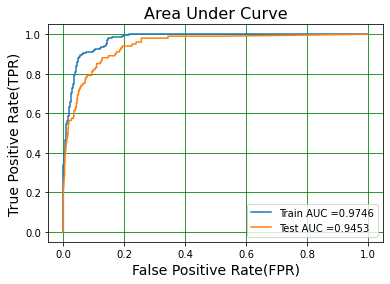

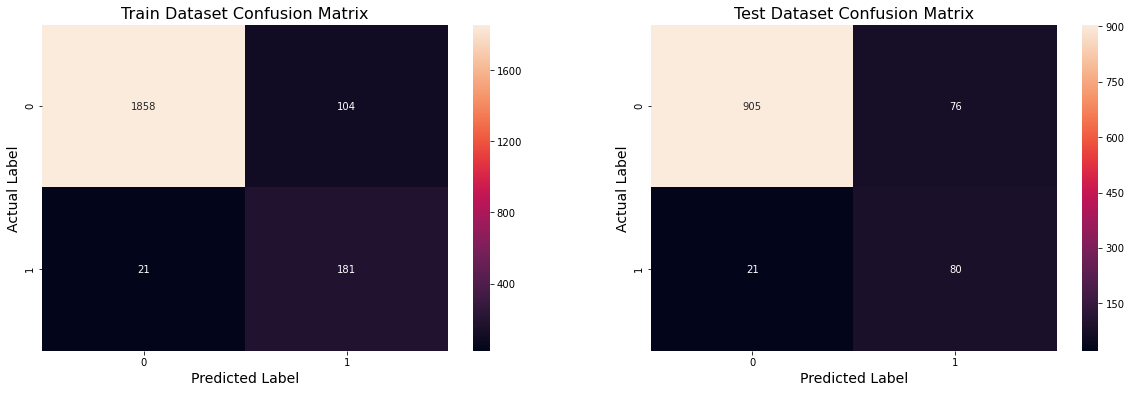

Best Threshold = 0.2087
Model AUC is : 0.9453
Model F1 Score is : 0.6226


In [48]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [116]:
combined_table.append_row(["LR + RF", "80", "0.9453", "0.6226"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+


#### MetaModel - SVC

In [49]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93261707        nan 0.933446  ]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.93359997        nan 0.93432641]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [50]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9334460045887653


In [51]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9341346978734572
Test AUC =  0.948547148292811


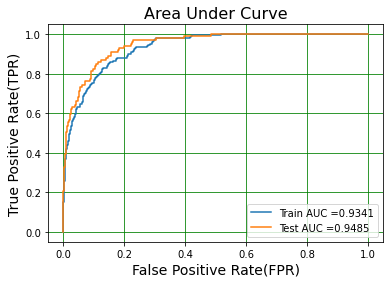

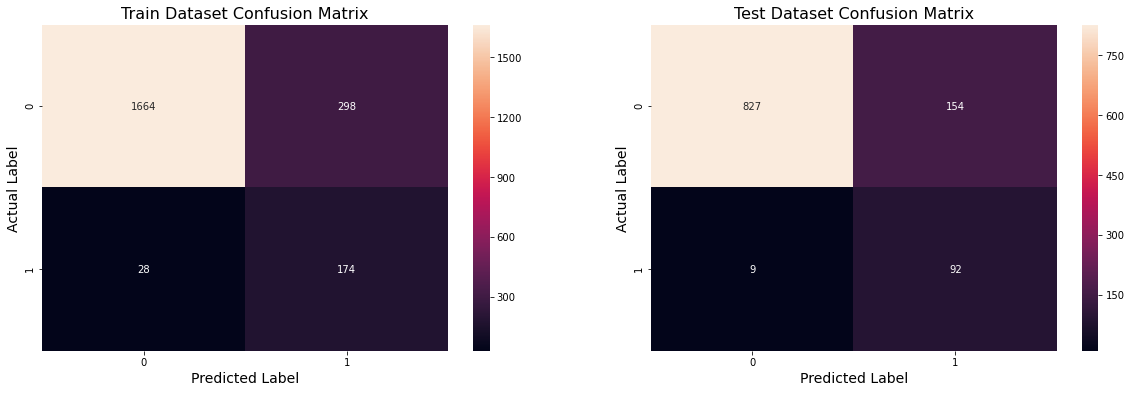

Best Threshold = 0.0576
Model AUC is : 0.9485
Model F1 Score is : 0.5303


In [52]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [117]:
combined_table.append_row(["LR + SVC", "80", "0.9485", "0.5303"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+


## BaseLearner - SVM with Linear Kernel

In [53]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='linear')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9311926605504587
Test AUC =  0.9562983821317912


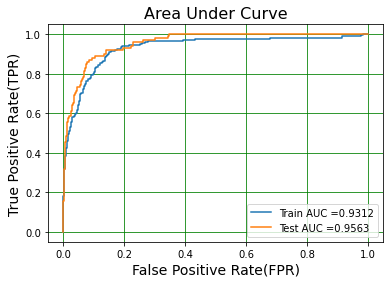

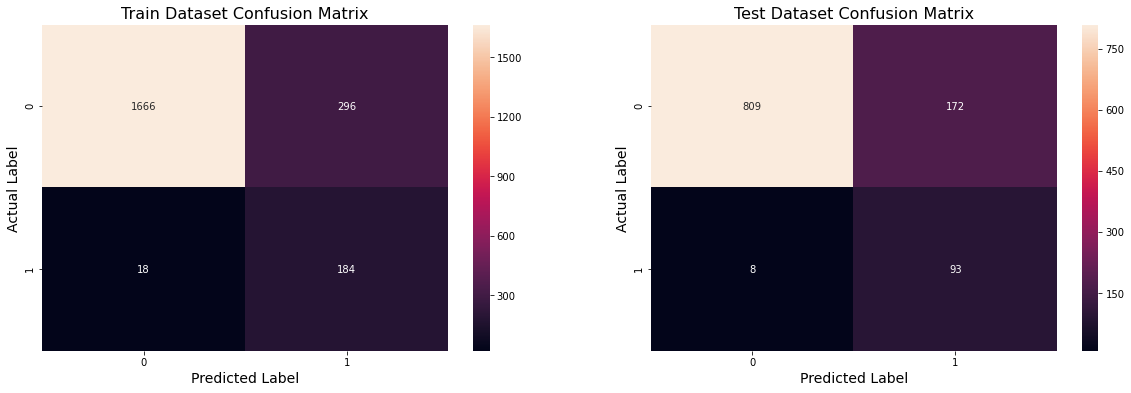

Best Threshold = 0.0932
Model AUC is : 0.9563
Model F1 Score is : 0.5082
						Number of base learners =  20
Train AUC =  0.9380279771096375
Test AUC =  0.9616172626436955


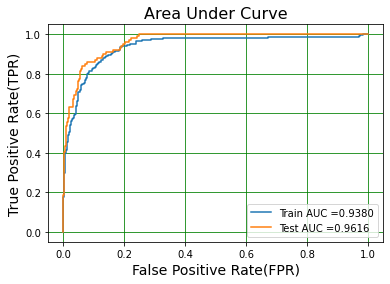

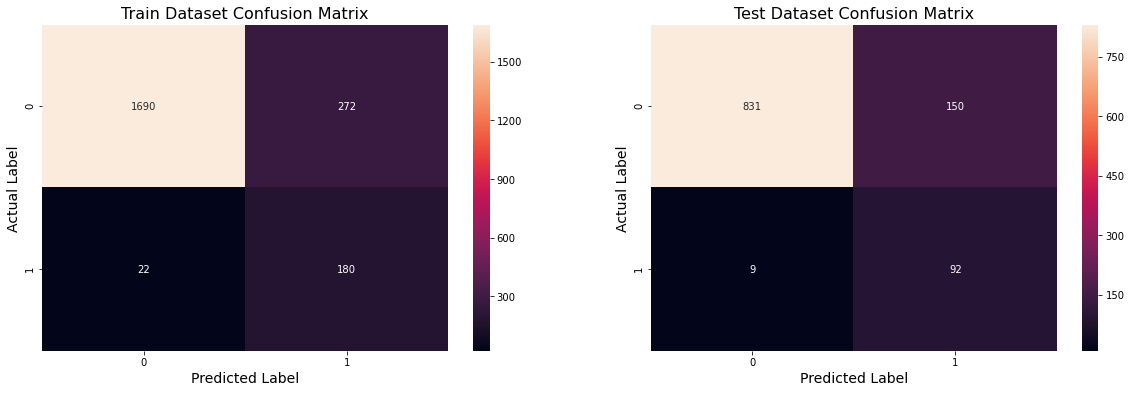

Best Threshold = 0.0932
Model AUC is : 0.9616
Model F1 Score is : 0.5364
						Number of base learners =  50
Train AUC =  0.9381692756431605
Test AUC =  0.9631816392648439


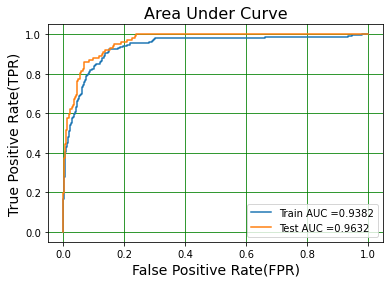

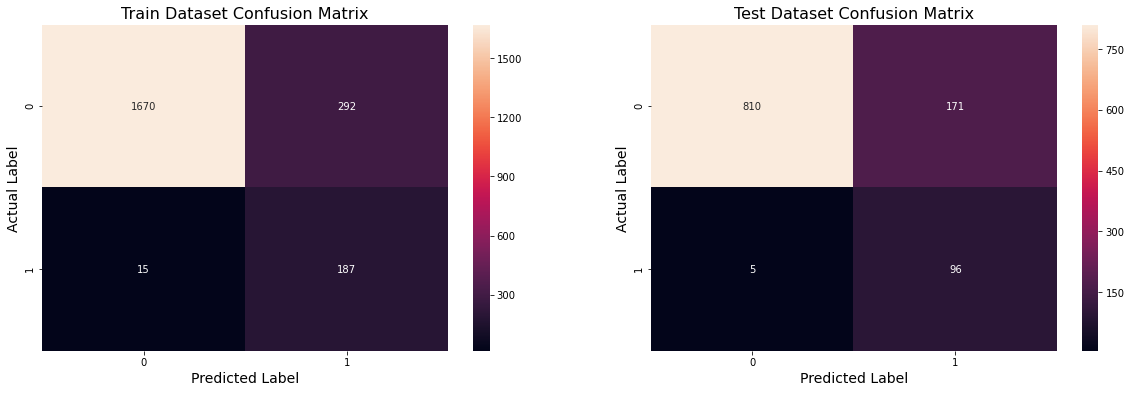

Best Threshold = 0.0928
Model AUC is : 0.9632
Model F1 Score is : 0.5217
						Number of base learners =  80
Train AUC =  0.9388000726678173
Test AUC =  0.9620310654918702


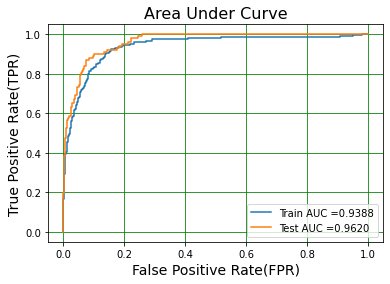

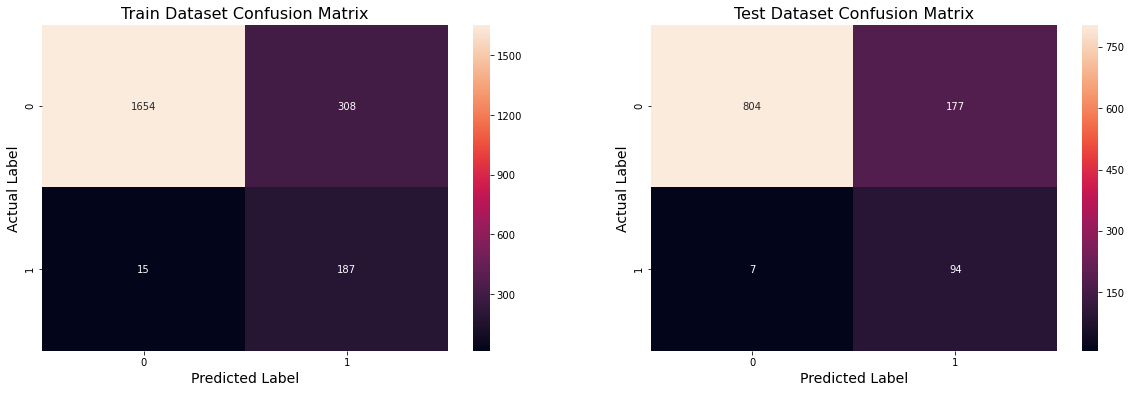

Best Threshold = 0.0924
Model AUC is : 0.9620
Model F1 Score is : 0.5054
						Number of base learners =  100
Train AUC =  0.9393627436138109
Test AUC =  0.9640395232183768


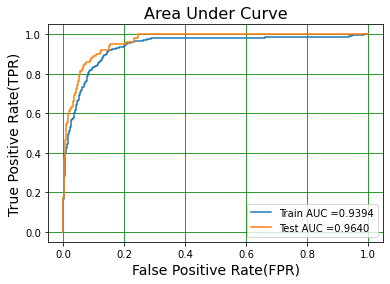

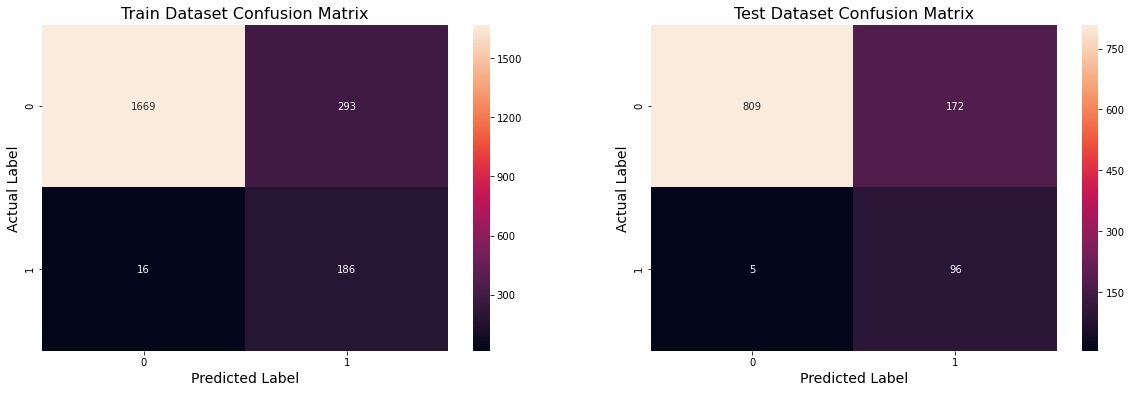

Best Threshold = 0.0921
Model AUC is : 0.9640
Model F1 Score is : 0.5203
						Number of base learners =  150
Train AUC =  0.9391634117540193
Test AUC =  0.9641909145042945


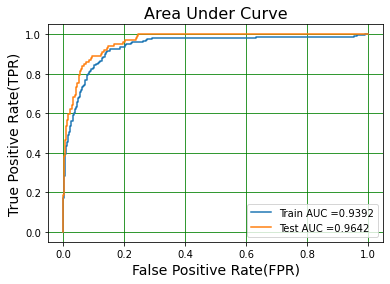

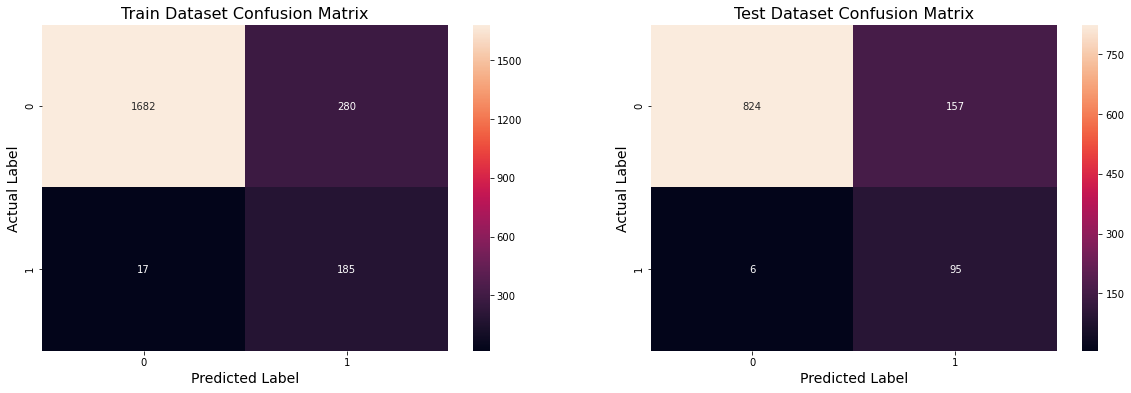

Best Threshold = 0.0916
Model AUC is : 0.9642
Model F1 Score is : 0.5382


In [54]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.0001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Model is working best when number of base learners, k = 50 when base learner is SVM with linear kernel.

Now use k=50 and different meta model.

#### Meta Model = LogisticRegression

In [55]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [56]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [57]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93798953        nan 0.93796517        nan 0.93804039
        nan 0.93565599        nan 0.90722295        nan 0.86795493
        nan 0.84817316]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.9384844         nan 0.93858455        nan 0.93864548
        nan 0.93605024        nan 0.92352923        nan 0.9121662
        nan 0.90505294]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [58]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9380403887024927


Train AUC =  0.9387445625296474
Test AUC =  0.9629495059597702


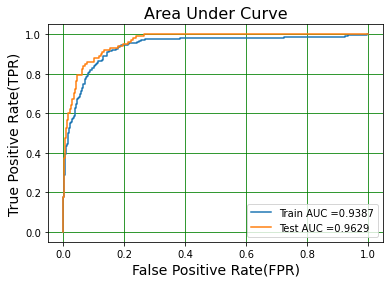

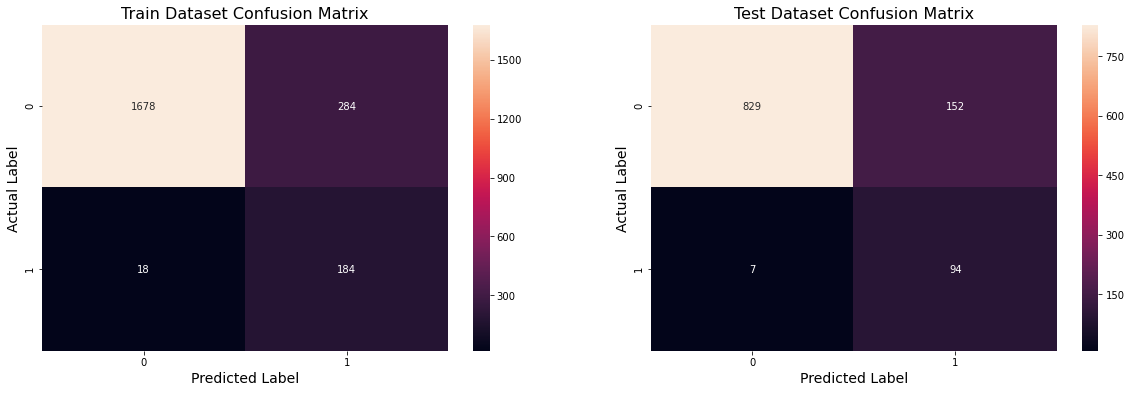

Best Threshold = 0.0539
Model AUC is : 0.9629
Model F1 Score is : 0.5418


In [59]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [118]:
combined_table.append_row(["SVM(Linear) + LR", "50", "0.9629", "0.5418"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - Random Forest

In [60]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [61]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 5}
roc_auc_score : 0.943101738740553


In [63]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9805411733833934
Test AUC =  0.9629696914645592


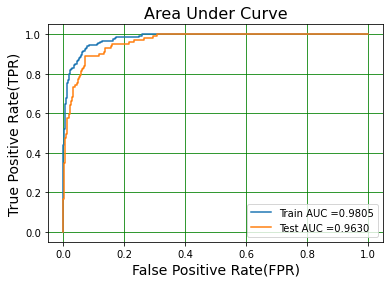

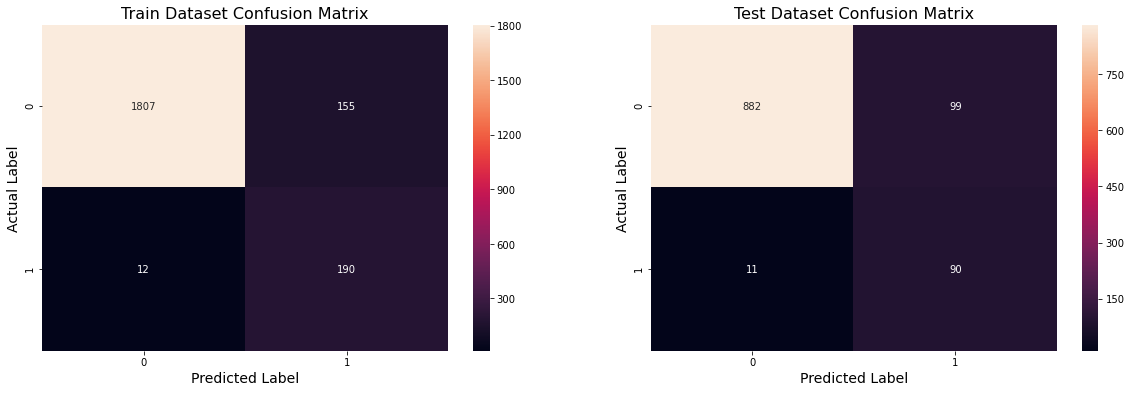

Best Threshold = 0.1653
Model AUC is : 0.9630
Model F1 Score is : 0.6207


In [64]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [119]:
combined_table.append_row(["SVM(Linear) + RF", "50", "0.9630", "0.6207"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

## BaseLearner - SVM with rbf Kernel

In [65]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='rbf')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.8232960910769975
Test AUC =  0.8794723509048152


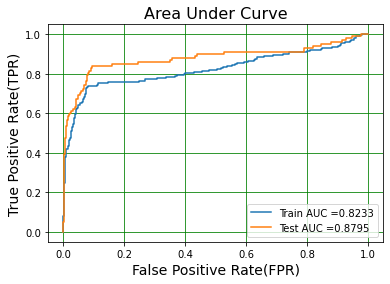

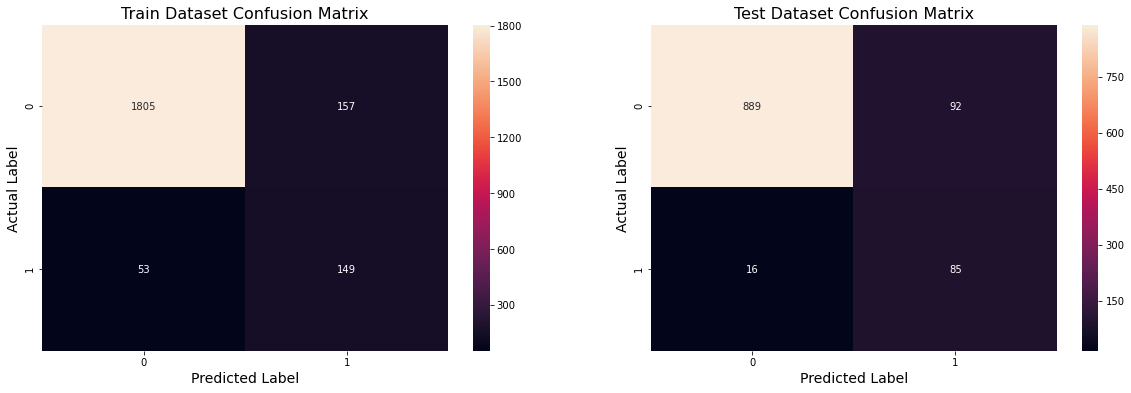

Best Threshold = 0.0921
Model AUC is : 0.8795
Model F1 Score is : 0.6115
						Number of base learners =  20
Train AUC =  0.79112796600761
Test AUC =  0.85876202299129


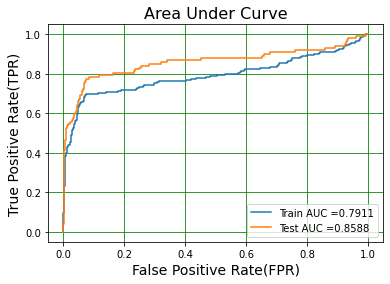

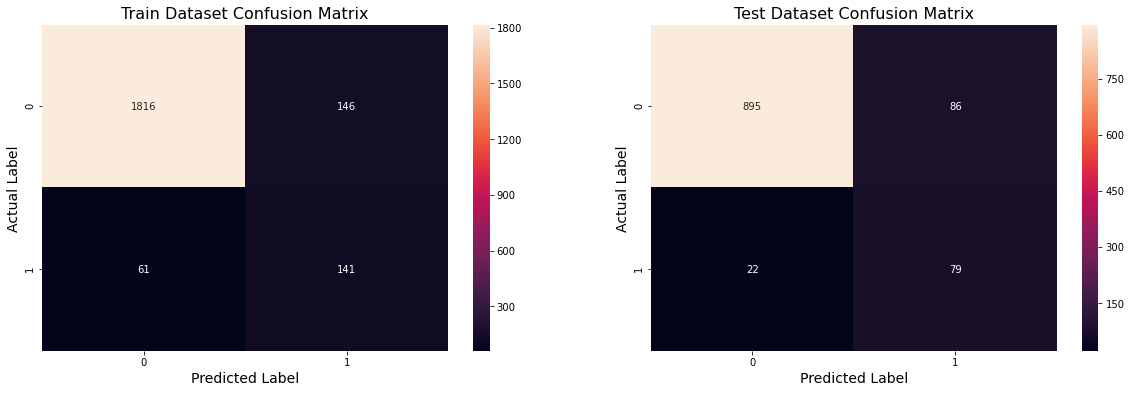

Best Threshold = 0.0908
Model AUC is : 0.8588
Model F1 Score is : 0.5940
						Number of base learners =  50
Train AUC =  0.8099660883519544
Test AUC =  0.8722964039523219


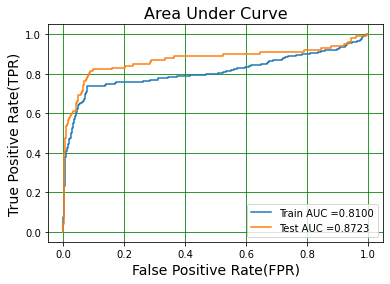

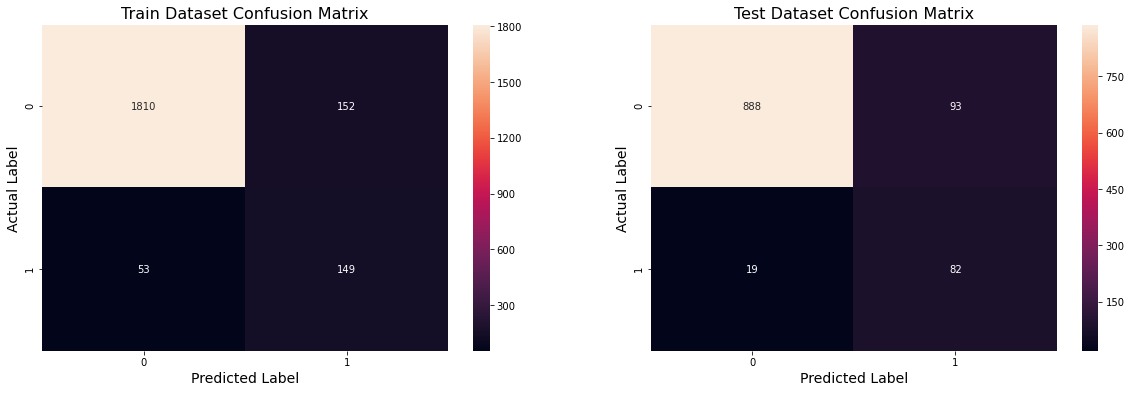

Best Threshold = 0.0859
Model AUC is : 0.8723
Model F1 Score is : 0.5942
						Number of base learners =  80
Train AUC =  0.8083033073949597
Test AUC =  0.8729423401055701


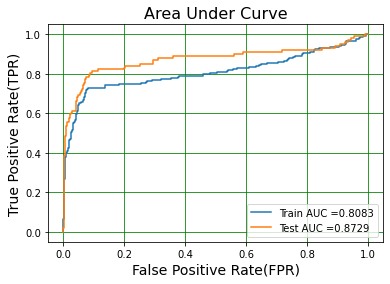

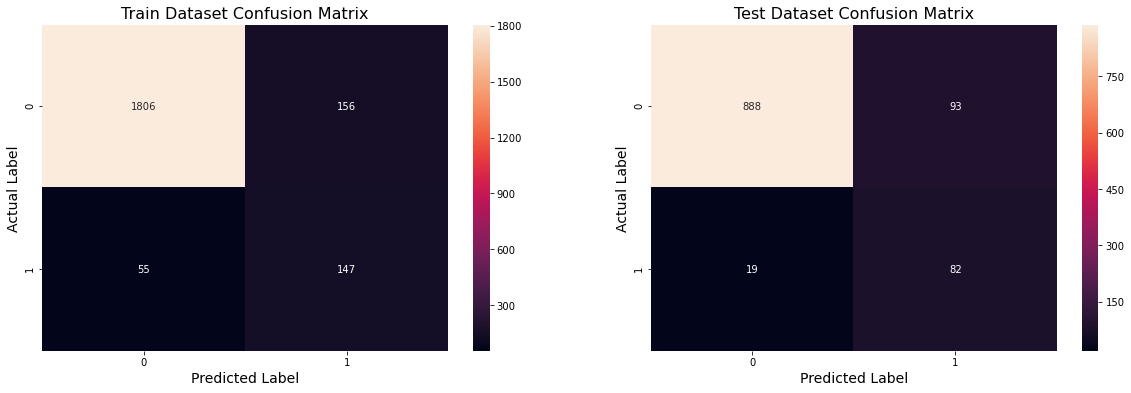

Best Threshold = 0.0820
Model AUC is : 0.8729
Model F1 Score is : 0.5942
						Number of base learners =  100
Train AUC =  0.8130191459512924
Test AUC =  0.8736286472683966


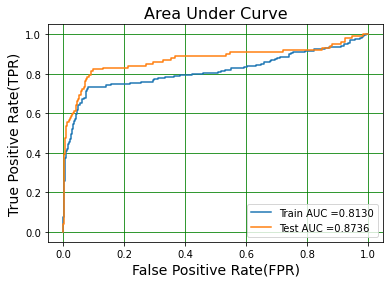

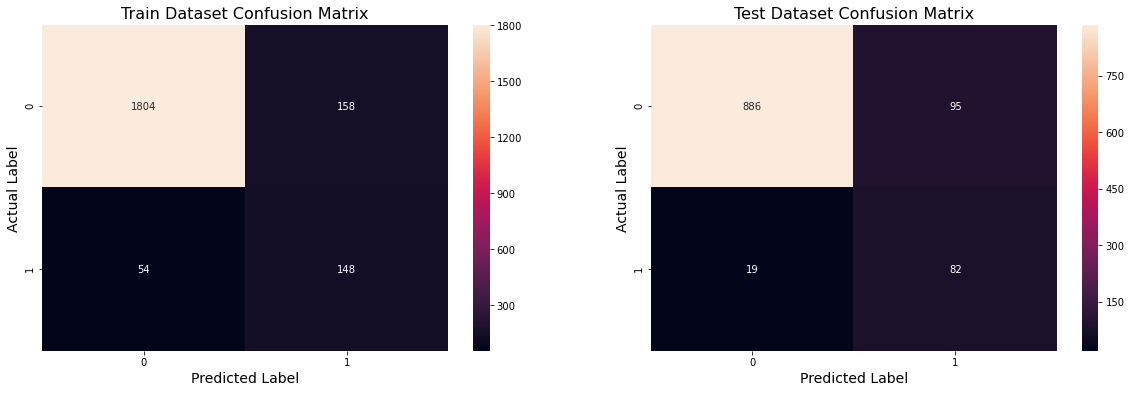

Best Threshold = 0.0802
Model AUC is : 0.8736
Model F1 Score is : 0.5899
						Number of base learners =  150
Train AUC =  0.8118887576831079
Test AUC =  0.8731240096486714


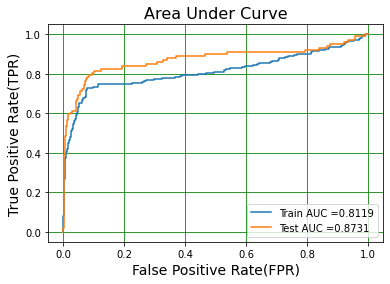

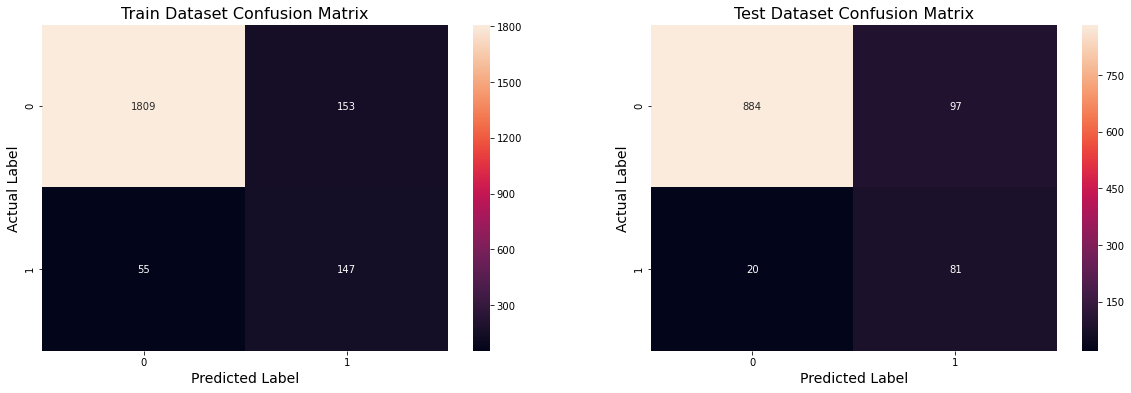

Best Threshold = 0.0759
Model AUC is : 0.8731
Model F1 Score is : 0.5806


In [66]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

All the models are not performing good. Still it is working comperatively better whrn k =50.

#### Meta Model = LogisticRegression

In [67]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [68]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [69]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.8173511         nan 0.81852142        nan 0.82669084
        nan 0.86009105        nan 0.88260148        nan 0.86240205
        nan 0.84982764]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.81766834        nan 0.81914998        nan 0.82742333
        nan 0.8633985         nan 0.88711391        nan 0.89004039
        nan 0.88603106]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [70]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 10.0, 'penalty': 'l2'}
roc_auc_score : 0.8826014779864655


Train AUC =  0.8875087049989402
Test AUC =  0.9134041844551426


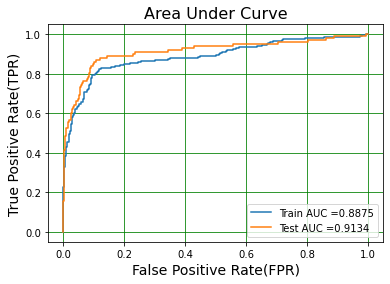

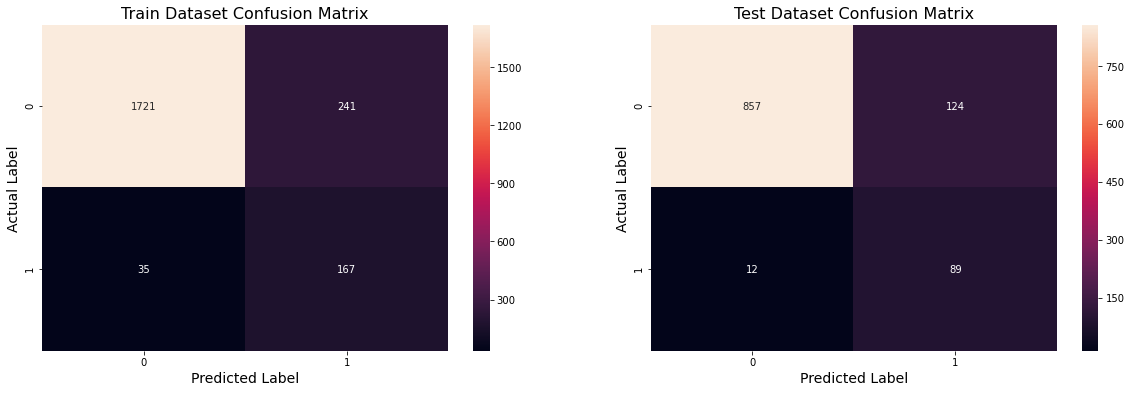

Best Threshold = 0.0487
Model AUC is : 0.9134
Model F1 Score is : 0.5669


In [71]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=10.0, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [120]:
combined_table.append_row(["SVM(rbf) + LR", "50", "0.9134", "0.5669"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - Random Forest

In [72]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [73]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 10}
roc_auc_score : 0.930122160994355


In [78]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9685257516577346
Test AUC =  0.9456051109698125


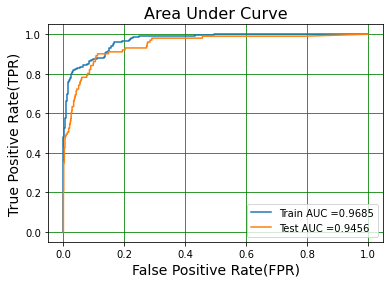

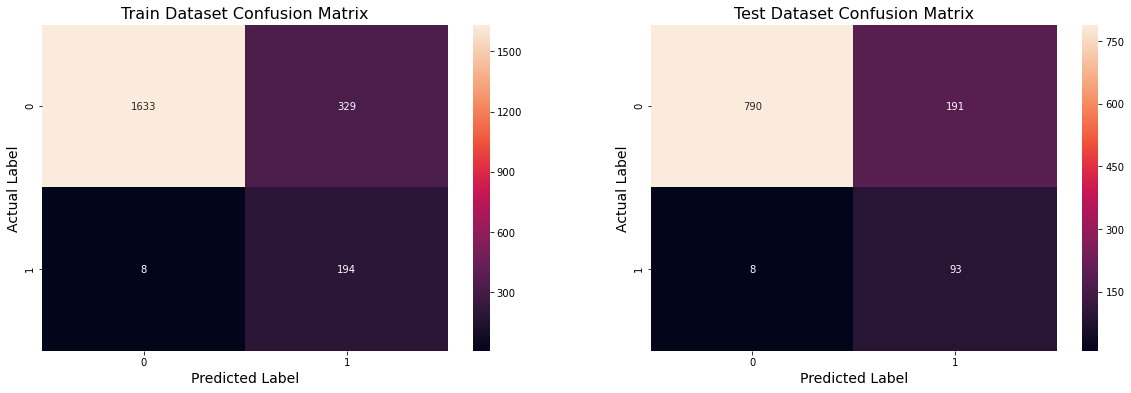

Best Threshold = 0.0448
Model AUC is : 0.9456
Model F1 Score is : 0.4831


In [79]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [121]:
combined_table.append_row(["SVM(rbf) + RF", "50", "0.9456", "0.4831"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

## BaseLearner - XGBClassifier

In [80]:
from xgboost import XGBClassifier
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = XGBClassifier(learning_rate=0.1, max_delta_step=0, max_depth=10)
        # base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9382197394051333
Test AUC =  0.9570654313137736


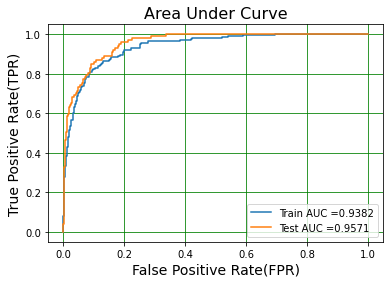

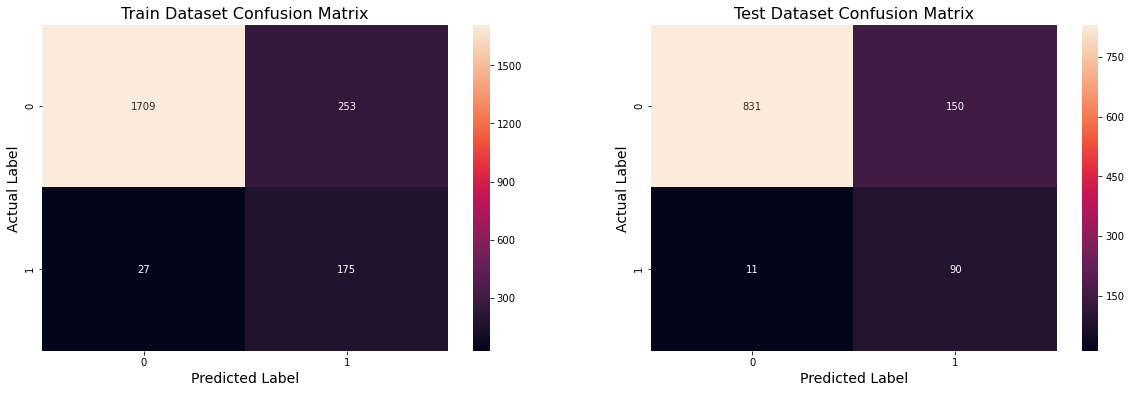

Best Threshold = 0.0910
Model AUC is : 0.9571
Model F1 Score is : 0.5279
						Number of base learners =  20
Train AUC =  0.9322473531756845
Test AUC =  0.9552790141399461


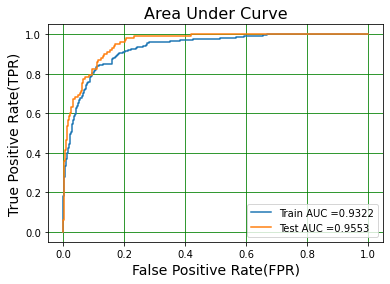

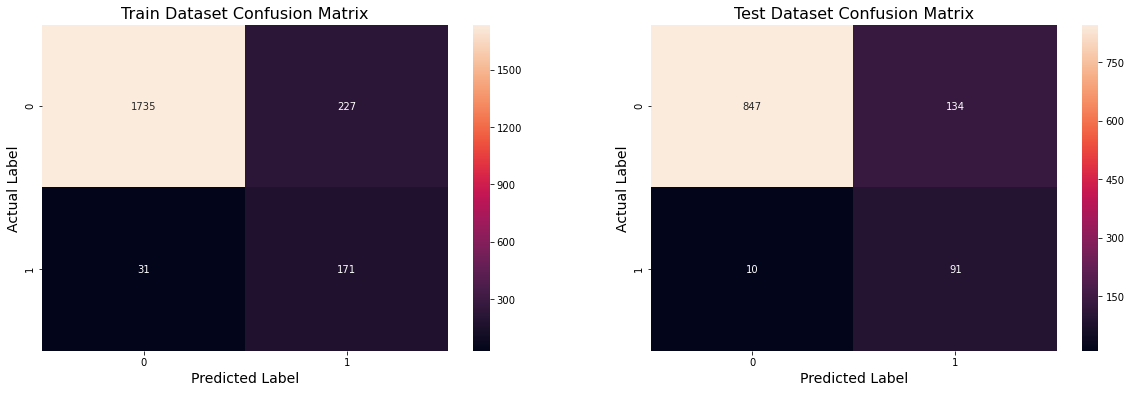

Best Threshold = 0.0900
Model AUC is : 0.9553
Model F1 Score is : 0.5583
						Number of base learners =  50
Train AUC =  0.9336098747489427
Test AUC =  0.9561974546078461


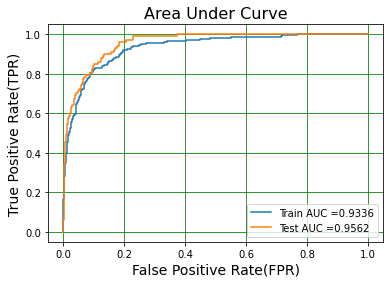

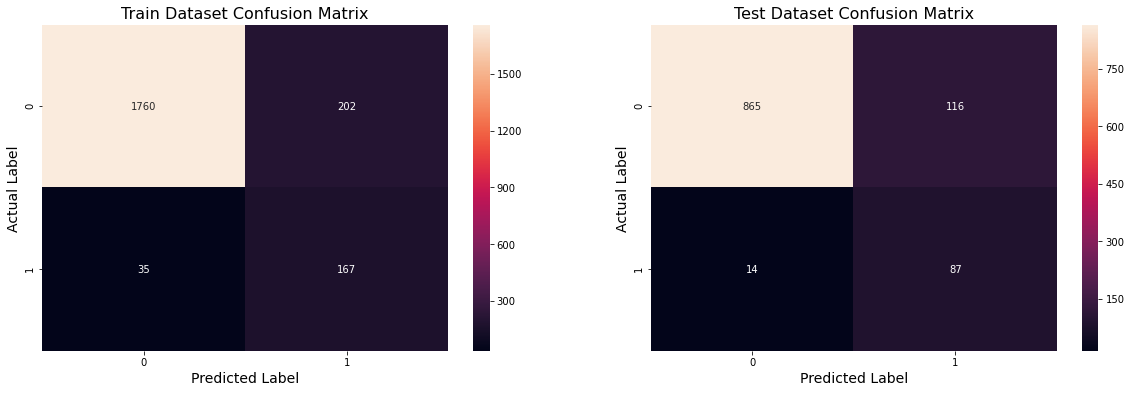

Best Threshold = 0.0850
Model AUC is : 0.9562
Model F1 Score is : 0.5724
						Number of base learners =  80
Train AUC =  0.9351692049938939
Test AUC =  0.9594271353740879


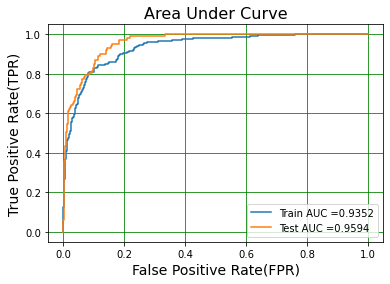

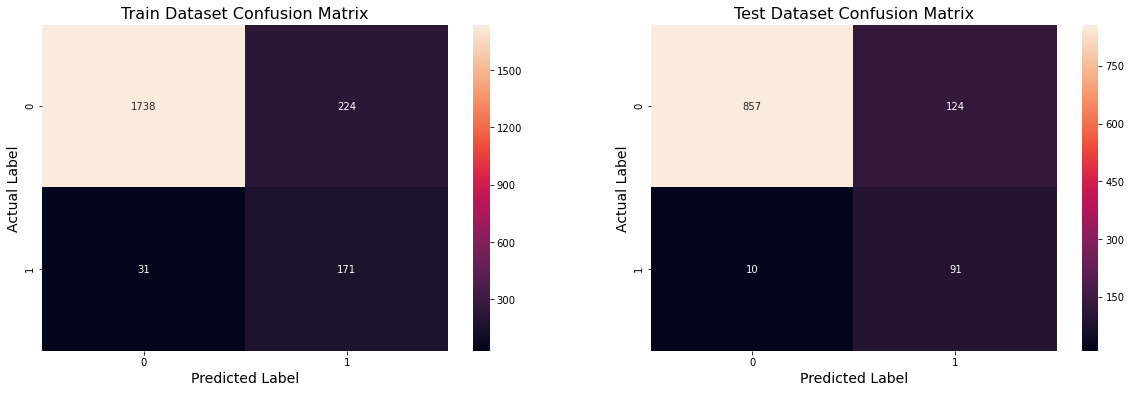

Best Threshold = 0.0771
Model AUC is : 0.9594
Model F1 Score is : 0.5759
						Number of base learners =  100
Train AUC =  0.9335922124322524
Test AUC =  0.9576407182002604


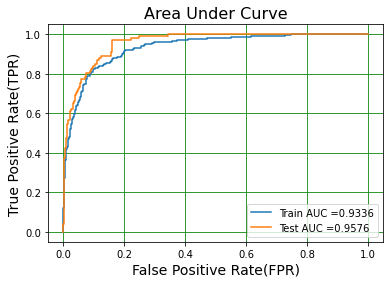

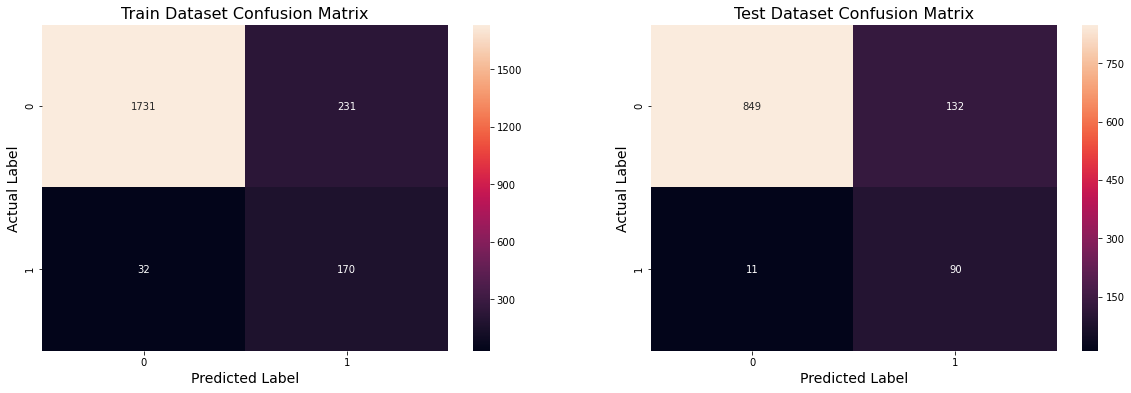

Best Threshold = 0.0736
Model AUC is : 0.9576
Model F1 Score is : 0.5573
						Number of base learners =  150
Train AUC =  0.9343163674165583
Test AUC =  0.9568232052563055


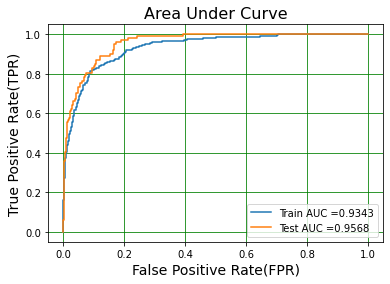

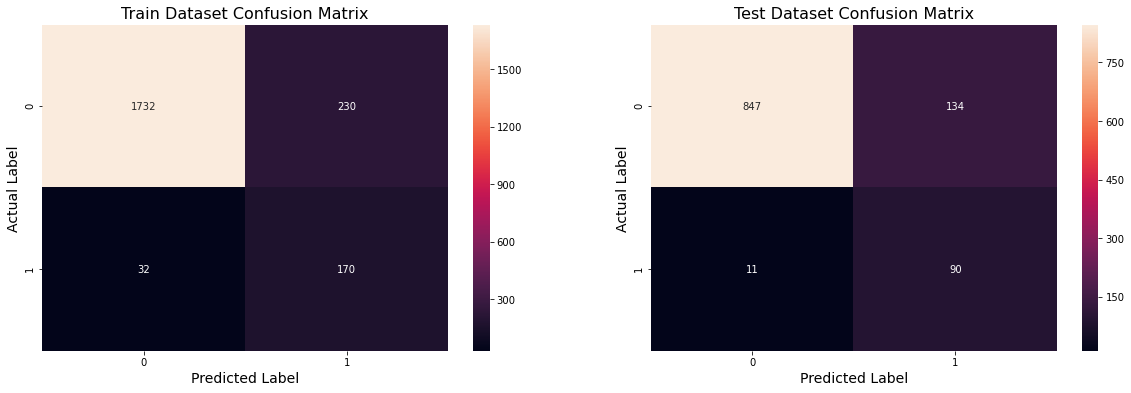

Best Threshold = 0.0680
Model AUC is : 0.9568
Model F1 Score is : 0.5538


In [81]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Model is working best when k = 80.

#### Meta Model - LogisticRegression

In [82]:
# create 50 sampled dataset
k = 80
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [83]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [84]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.93273546        nan 0.93280042        nan 0.93252767
        nan 0.91150681        nan 0.84389991        nan 0.7907873
        nan 0.7808382 ]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.93281732        nan 0.93318467        nan 0.93519329
        nan 0.92964438        nan 0.92268773        nan 0.91558432
        nan 0.9154543 ]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [85]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.01, 'penalty': 'l2'}
roc_auc_score : 0.9328004197396702


Train AUC =  0.9331481313268942
Test AUC =  0.9579031297625175


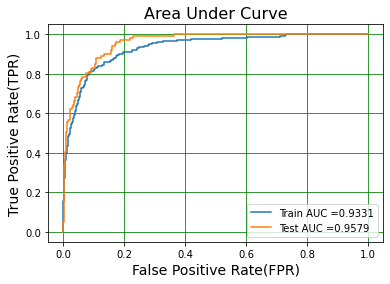

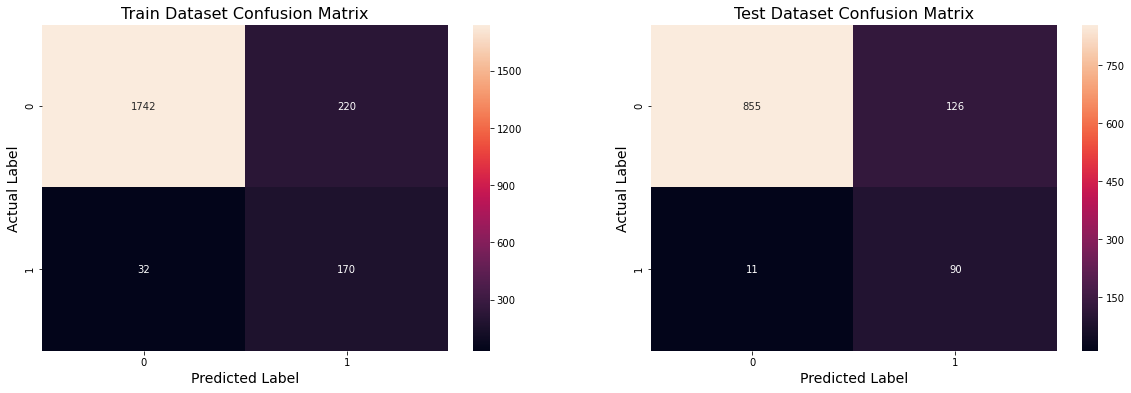

Best Threshold = 0.0553
Model AUC is : 0.9579
Model F1 Score is : 0.5678


In [86]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.01, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [122]:
combined_table.append_row(["XGBClf + LR", "80", "0.9579", "0.5678"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - Random Forest

In [87]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [88]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 5}
roc_auc_score : 0.9360708799904248


In [89]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=5,
                       n_estimators=400, random_state=42)

Train AUC =  0.9791029561671765
Test AUC =  0.9594170426216934


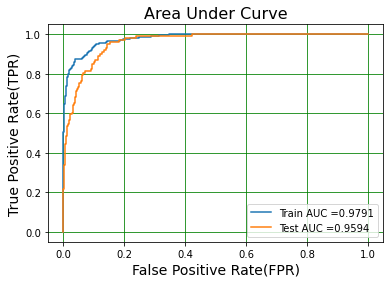

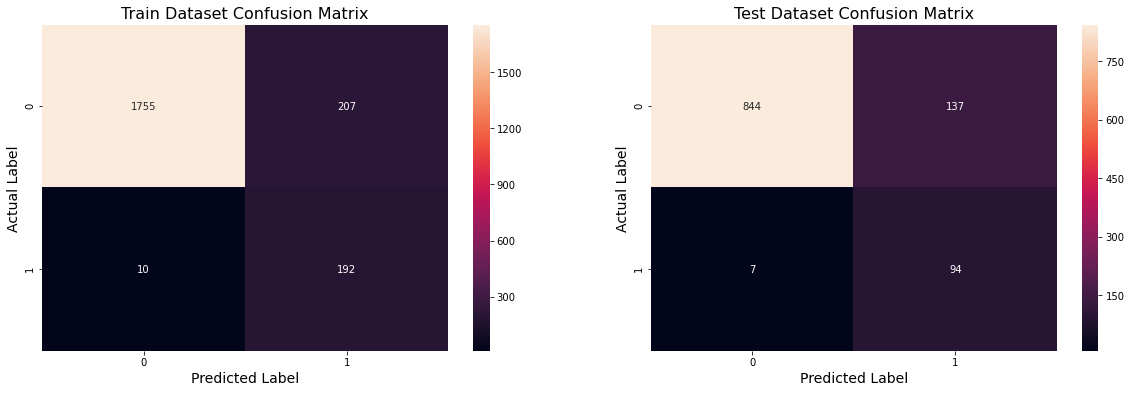

Best Threshold = 0.1038
Model AUC is : 0.9594
Model F1 Score is : 0.5663


In [90]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [123]:
combined_table.append_row(["XGBClf + RF", "80", "0.9594", "0.5663"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - SVC

In [91]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.83889571        nan 0.81568992]
  category=UserWarning
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [       nan 0.91760061        nan 0.91470905]
  category=UserWarning


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [92]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.8388957143553754


In [93]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5))

Train AUC =  0.9172141984840685
Test AUC =  0.9025746611358382


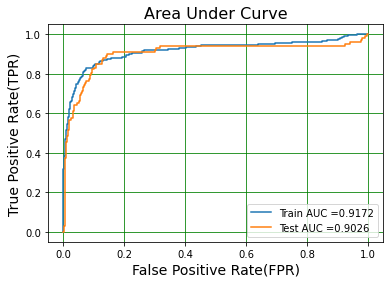

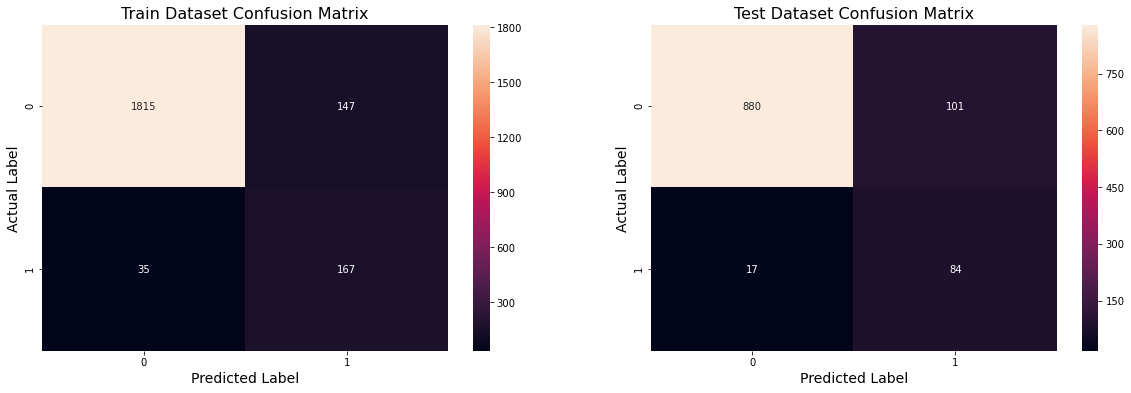

Best Threshold = 0.0758
Model AUC is : 0.9026
Model F1 Score is : 0.5874


In [94]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [124]:
combined_table.append_row(["XGBClf + LinearSVC", "80", "0.9026", "0.5874"])
print(combined_table)

+--------------------+---------------------+-------+----------+
| Model Combination  | No of base Learners |  AUC  | F1 Score |
+--------------------+---------------------+-------+----------+
|      DT + LR       |         50          | 0.953 |  0.544   |
+--------------------+---------------------+-------+----------+
|      DT + DT       |         50          | 0.914 |   0.5    |
+--------------------+---------------------+-------+----------+
|      DT + SVC      |         50          | 0.942 |  0.503   |
+--------------------+---------------------+-------+----------+
|      DT + RF       |         50          | 0.955 |  0.551   |
+--------------------+---------------------+-------+----------+
|      LR + RF       |         80          | 0.945 |  0.623   |
+--------------------+---------------------+-------+----------+
|      LR + SVC      |         80          | 0.949 |   0.53   |
+--------------------+---------------------+-------+----------+
|  SVM(Linear) + LR  |         50       

## Observation:
Comparing AUC and F1 score for all the combination tried, SVM with linear kernel with 50 base learner and Random forest meta model working the best. <br> AUC = 0.963 and F1 Score =  0.621 

### Train the model which gave the best result

In [125]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='linear')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

In [126]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [127]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [128]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9813031761891785
Test AUC =  0.9644028623045791


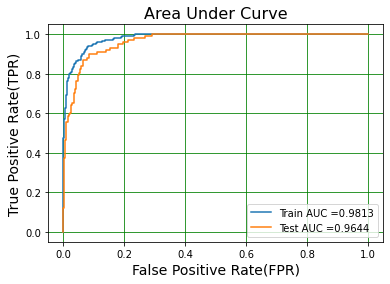

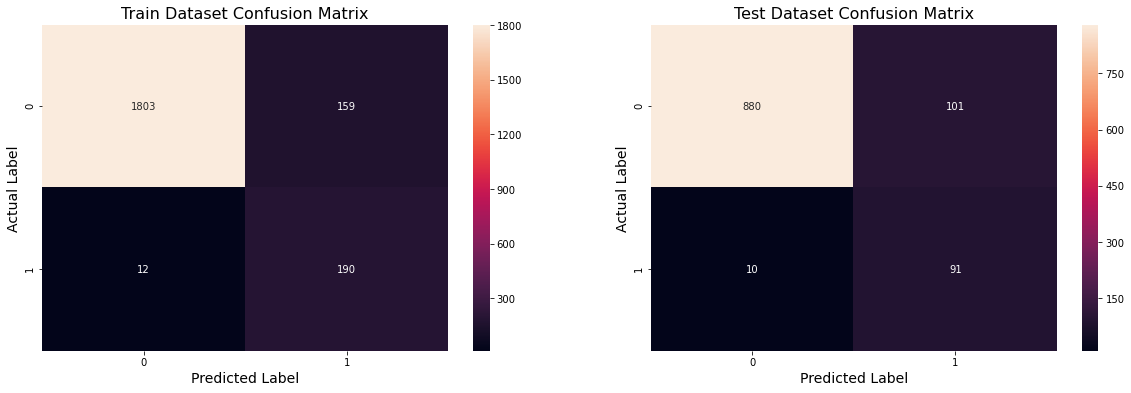

Best Threshold = 0.1716
Model AUC is : 0.9644
Model F1 Score is : 0.6212


In [129]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

# Conclusion:
Model performance is increased in terms of both AUC and F1 score using ensemble model (Linear SVM + RF) than using a single first cut model.

#### Add the predicted labels to the dataframe containing original label

In [130]:
y_val_pred = pred_prob(random_forest, x_val_meta_model)
y_val_prediction = predict_with_best_t(y_val_pred, best_t)
x_validation_provider_labels['Predicted_Label'] = y_val_prediction
x_validation_provider_labels = x_validation_provider_labels.reset_index(drop=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
x_validation_provider_labels.head(10)

,Provider,PotentialFraud,Predicted_Label
0,PRV52573,0,0
1,PRV52731,0,0
2,PRV53323,0,0
3,PRV53166,0,0
4,PRV56177,0,0
5,PRV52878,0,0
6,PRV54477,0,0
7,PRV51176,0,0
8,PRV56819,0,1
9,PRV52599,0,0


In [132]:
x_validation_provider_labels.tail(10)

,Provider,PotentialFraud,Predicted_Label
1072,PRV53752,0,0
1073,PRV53539,0,0
1074,PRV52417,0,0
1075,PRV56528,0,0
1076,PRV52340,1,1
1077,PRV53129,0,0
1078,PRV51209,0,0
1079,PRV55446,0,0
1080,PRV56346,0,0
1081,PRV56080,0,0
